# 📌 분석 목표
은하 집단의 마그네슘 함량 지표에 젊고 뜨거운 별이 영향을 미치는지 확인한다.

이를 위해 은하 집단을 젊고 뜨거운 별의 영향을 받은 집단과 영향을 받지 않은 집단으로 나누어

두 집단의 평균의 차이가 표본 오차에 의한 것인지 또는 두 집단의 속성에 의한 것인지 밝힌다.

# 📌 가설 수립
### 귀무가설($H0$): 
젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단을 비교할 때, 두 집단의 마그네슘 함량 지표(Mgb/Fe, Mg2/Fe)의 평균은 같다.
### 대립가설($H1$): 
젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단을 비교할 때, 두 집단의 마그네슘 함량 지표(Mgb/Fe, Mg2/Fe)의 평균은 다르다.

# 📌 가설 검정
### 유의수준 5%에서 평균검정

# 1. 데이터 로드
사전에 은하의 ID로 동일하게 indexing 된 5개의 데이터 로드

In [2]:
import numpy as np
from scipy import stats
from scipy.stats import norm

import os.path
import pymfits as fits

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.table import Table
from astropy.cosmology import WMAP7

# 1.Spectroscopy
mpa_emi = fits.mrdfits('../SpecGalaxy_MPA_MATCHED_EMISSION.fits', 1) #'SN_MEDIAN'
mpa_emi_ew = fits.mrdfits('../SpecGalaxy_MPA_MATCHED_EQW.fits', 1) # EMISSION LINES'S EW
#mpa = fits.mrdfits('../SpecGalaxy_MPA_MATCHED.fits', 1)
#ossy = fits.mrdfits('../SpecGalaxy_OSSY_MATCHED.fits', 1)

# 2.Magnitude #K-corrected
data = fits.mrdfits('../SpecGalaxy_final_v2_err.fits', 1) #PETROMAG UGRIZ, PETROMAGerror, MODELMAG UGRIZ, VMAX

# 3.UV, NUV&FUV mag #K-corrected
galex = fits.mrdfits('../SpecGalaxy_GALEX_KCORRECTED.fits', 1) #SDSSID, GALEXID, RA, DEC, Z, NUV_R, NUV_MAG, NUV_MAGERR, FUV_MAG, FUV_MAGERROR, E_BV, MATCHED, ALLDATA, ONLYNUV, ONLYFUV, SEPARATION

# 4.Original Magnitude #Not K-corrected
#phot = fits.mrdfits('../SpecGalaxy_phot.fits', 1)   #BESTOBJID, PETROMAG UGRIZ, PETROMAGerror, EXTINCTION UGRIZ

# 5.Morp, Galxy Zoo
morp = fits.mrdfits('../SpecGalaxy_GZ_MATCHED.fits', 1)#OBJID, 'RA','DEC','MORP_GZ', GZMATCHED

# 6.Stellar Mass
#mendel = fits.mrdfits('../SpecGalaxy_MENDEL_MATCHED.fits', 1)

# 7.size, structure
#struct = fits.mrdfits('../SpecGalaxy_Struct_MATCHED.fits', 1)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    #https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {'red': [],'green': [],'blue': [],'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

#  tick label size
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

# 2. 데이터 추출
### 5개의 데이터에서 조건을 만족하는 데이터를 추출

### 도구:  Numpy
#### Why Numpy?
- Numpy was faster than Pandas in all operations but was specially optimized when querying.
- https://towardsdatascience.com/speed-testing-pandas-vs-numpy-ffbf80070ee7

In [2]:
###############################################################
# 1) 'Peek&Graves 2.2 Galaxy Selection Criteria'
# => Remove low-S/N spectra (S/N < 5Å−1)
###############################################################
w = np.where(mpa_emi['SN_MEDIAN']>=5)
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(mpa_emi))
###############################################################
# 2) (galex['alldata'] == NUV, FUV 존재) & (morp['morp_gz'] == ETG)& 
#       & morp['gzmatched'] == 1 mpa_emi['MATCHED']==1, galex['MATCHED'] =1, 
# elements = ['CN2', 'CA4227','CA4455', 'HB', 'MG2', 'MGB', 'FE5270', 'FE5335’] 에 대하여 -10<lick<10
# galex['nuv_mag']>-100
#(galex['fov_radius'] < 0.6)
#& (mpa_emi['V_DISPEFF']>=0))
###############################################################
w = np.where((morp['morp_gz'] == 1))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

w = np.where((morp['gzmatched'] == 1) & (mpa_emi['MATCHED']==1))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

w = np.where( (mpa_emi['LICK_CN2'] > -10) & (mpa_emi['LICK_CA4227'] > -10) & (mpa_emi['LICK_CA4455'] > -10) & (mpa_emi['LICK_HB'] > -10) & (mpa_emi['LICK_MG2'] > -10) & (mpa_emi['LICK_MGB'] > -10) & (mpa_emi['LICK_FE5270'] > -10)& (mpa_emi['LICK_FE5335'] > -10))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

w = np.where((mpa_emi['LICK_CN2'] < 10) & (mpa_emi['LICK_CA4227'] <10) & (mpa_emi['LICK_CA4455'] <10) & (mpa_emi['LICK_HB'] <10) & (mpa_emi['LICK_MG2'] <10) & (mpa_emi['LICK_MGB'] <10) & (mpa_emi['LICK_FE5270'] <10)& (mpa_emi['LICK_FE5335'] <10))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

w = np.where((np.log10(mpa_emi['V_DISPEFF'])>=1.4) & (np.log10(mpa_emi['V_DISPEFF'])<=2.8))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

678251
61620
61620
58432
58412
57513


<ipython-input-2-f02c95ad1969>:32: RuntimeWarning: invalid value encountered in log10
  w = np.where((np.log10(mpa_emi['V_DISPEFF'])>=1.4) & (np.log10(mpa_emi['V_DISPEFF'])<=2.8))


# 3. 데이터 전처리
# 3-1. 이상치 처리 1: $|X_{err}| <= \mu \pm 3 \sigma$

In [3]:
# ###############################################################
# #3) 'Lick Error <= 3 Sigma Galaxies
# ###############################################################
elements = ['CN2', 'CA4227','CA4455', 'HB', 'MG2', 'MGB', 'FE5270', 'FE5335']
for i in range(len(elements)):
    n = 'LICK_' + elements[i] 
    en = n + '_ERR'
    y = mpa_emi[n] #Lick
    yerr = mpa_emi[en]        
    w = np.where(np.abs(yerr) <= (np.mean(yerr) + 3*np.std(yerr)))
    data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 

print('After data cleaning 1st method', len(data))

After data cleaning 1st method 55135


# 3-2. 이상치 처리 2
## 데이터 단위 변환: Å으로 통일
## Error propagation: $X_{err}$, $<Fe>_{err}$ => $|\frac{X}{<Fe>}_{err}|$
## 이상치 처리: $|\frac{X}{<Fe>}_{err}|$ <= \mu \pm 3 

In [4]:
def y_unit_change_to_Angstrom(y, xname):
    cn2_dlamb = 4178.375 - 4143.375   # [Anstrom]
    mg2_dlamb = 5196.625 - 5154.125 
    if xname == 'CN2':
        delta_lambda = cn2_dlamb 
    if xname == 'MG2':
        delta_lambda = mg2_dlamb 
    y_new = delta_lambda * (1-10**(y/(-2.5))) #[A]
    return y_new

def yerr_unit_change_to_Angstrom(y, yerr, xname):
    cn2_dlamb = 4178.375 - 4143.375   # [Anstrom]
    mg2_dlamb = 5196.625 - 5154.125 
    if xname == 'CN2':
        delta_lambda = cn2_dlamb 
    if xname == 'MG2':
        delta_lambda = mg2_dlamb 
    a = delta_lambda
    b = (-1)/(2.5)
    yerr_new = b* np.log(10) *(-a * 10**(b*y)) * yerr # Exponential function
    return yerr_new

In [5]:
# ###############################################################
# #4)'Lick/<Fe> Error <= 3 Sigma Galaxies
# ###############################################################
elements = ['CN2', 'CA4227','CA4455', 'HB', 'MG2', 'MGB', 'FE5270', 'FE5335']

for i in range(len(elements)):
    n = 'LICK_' + elements[i] 
    en = n + '_ERR'
    y = mpa_emi[n] #Lick
    yerr = mpa_emi[en]
    #############################
    # 데이터 단위 변환 [Angstrom]
    if elements[i] == 'CN2':
        y = y_unit_change_to_Angstrom(y, 'CN2')
        yerr = yerr_unit_change_to_Angstrom(y, yerr, 'CN2')
    if elements[i] == 'MG2':
        y = y_unit_change_to_Angstrom(y, 'MG2')
        yerr = yerr_unit_change_to_Angstrom(y, yerr, 'MG2')
        
    # Error propagation of feature ratio
    meanFe  = (mpa_emi['LICK_FE5270']+ mpa_emi['LICK_FE5335']) / 2
    meanFe_err = np.sqrt((mpa_emi['LICK_FE5270_ERR']**2 + mpa_emi['LICK_FE5335_ERR']**2)/2)
    yerr_a_Fe = np.abs((y / meanFe)) * np.sqrt( (yerr/y)**2 + (meanFe_err/meanFe)**2)
    
    # 이상치 처리: Lick/<Fe> Error > 3 Sigma 인 데이터 제외
    w = np.where(np.abs(yerr_a_Fe) <= (np.mean(yerr_a_Fe) + 3*np.std(yerr_a_Fe)))
    data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 

print('After data cleaning 2nd method', len(data))

After data cleaning 2nd method 51664


# 3-3. 이상치 처리 3

### 선행 연구의 demarcation curve를 사용한 이상치의 index 계산
Kauffmann et al. 2003 <br>
- 신호대잡음비(signal-to-noise ratio)가 3 이하인 데이터(S/N <=3) 중
- AGN hosting galaxies 3127개의 index 계산 

# of 4 emission line S/N> 3 galaxies  3583
# total sample  51664
# s/n >3 sample  3583
# Star Forming galaxies  456
# AGN hosting galaxies  3127
확인된 SF 은하 개수  456
제거할 AGN 은하 개수  3127


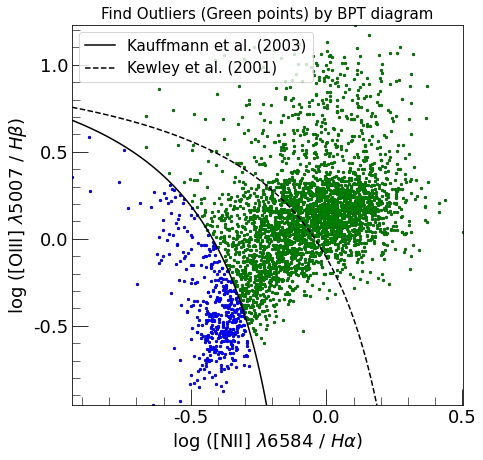

In [6]:
###############################################################
# 5) BPT diagram
###############################################################
data_sf, galex_sf, morp_sf, mpa_emi_sf, mpa_emi_ew_sf = data, galex, morp, mpa_emi, mpa_emi_ew
###############################################################
# 5-1) Kauffmann et al. 2003에 따라, 4 emission line의 S/N가 3 이하인 data를 제거
###############################################################
names = ['SN_OIII_5007', 'SN_H_BETA', 'SN_NII_6584', 'SN_H_ALPHA']
for n in names:
    w = np.where(mpa_emi_sf[n]>3)
    data_sf, galex_sf, morp_sf, mpa_emi_sf, mpa_emi_ew_sf = data_sf[w], galex_sf[w], morp_sf[w], mpa_emi_sf[w], mpa_emi_ew_sf[w] 
print('# of 4 emission line S/N> 3 galaxies ', len(mpa_emi_sf))

bpt_x = np.log10(mpa_emi_sf['NII_6584']/mpa_emi_sf['H_ALPHA'])
bpt_y = np.log10(mpa_emi_sf['OIII_5007']/mpa_emi_sf['H_BETA'])
############################################################
# 5-2) Among S/N > 3 samples find agn index
# Demarcation_curve
############################################################
ycurve_sf = 0.61/(bpt_x - 0.05) + 1.3 # Kauffmann et al. 2003

# y 값이 demarc line 이하에 위치한 데이터들의 index
sfidx = []
for i in range(len(bpt_y)):
    if bpt_y[i] <= ycurve_sf[i]:
        if bpt_x[i]<0:
            sfidx.append(i)
            
# y 값이 demarc line 초과에 위치한 데이터들의 index
agnidx = []
for i in range(len(bpt_y)):
    if i in sfidx:        continue
    else:        agnidx.append(i)
        
bpt_x_dem_sf = bpt_x[sfidx] # x-axis values of Star-forming sample at BPT diagram
bpt_y_dem_sf = bpt_y[sfidx] # y-axis values of Star-forming sample at BPT diagram
################################
# Select AGN candiated Sample
################################
bpt_x_dem_agn = np.delete(bpt_x, sfidx) # x-axis values of AGN sample at BPT diagram
bpt_y_dem_agn = np.delete(bpt_y, sfidx) # y-axis values of AGN sample at BPT diagram

print('# total sample ', len(data))
print('# s/n >3 sample ', len(data_sf))
print('# Star Forming galaxies ', len(bpt_x_dem_sf))
print('# AGN hosting galaxies ', len(bpt_x_dem_agn))

# ###############################################################
# 5-3) Among total S/N > 3 index, 
# A/B < demarc line 기준을 만족하는 은하의 index를 찾아서 total에 적용할 index에서 제거해준다.
# ###############################################################
#w # idx 1 : total 중에서 S/N > 3 index 495
#agnidx #idx 2 : S/N > 3 index중에서 agn index 407 / sf index 88

# idx1에서 idx2 번째에 있는 원소들을 제거해준다. new_a = np.delete(a, index)
agnidx = w[0][agnidx]
sfidx = w[0][sfidx]
print('확인된 SF 은하 개수 ', len(sfidx))
print('제거할 AGN 은하 개수 ', len(agnidx))

################################
# 5-4) Plot BPT diagram
################################
f = plt.figure(figsize=(7, 7))
ax_scatter = plt.axes()
xname = 'log ([NII] ' + r'$\lambda$' + '6584 / ' + r'$H\alpha$)'
yname = 'log ([OIII] ' + r'$\lambda$' + '5007 / ' + r'$H\beta$)'

# Data points
plt.scatter(bpt_x, bpt_y, c='k', s=5, alpha=0.7)
plt.scatter(bpt_x_dem_sf, bpt_y_dem_sf, c='b', s=5, alpha=0.7)
plt.scatter(bpt_x_dem_agn, bpt_y_dem_agn, c='g', s=5, alpha=0.7)

# Demarcation_curve
x = np.arange(np.min(bpt_x), -0.01, 0.01)
demarcation_curve_sf = 0.61/(x - 0.05) + 1.3  # Kauffmann et al. 2003
demarcation_curve_agn = 0.61/(np.arange(np.min(bpt_x), 0.2, 0.01) - 0.47) + 1.19  #Kewley et al. 2001
plt.plot(x, demarcation_curve_sf, c='k', label='Kauffmann et al. (2003)')
plt.plot(np.arange(np.min(bpt_x), 0.2, 0.01), demarcation_curve_agn, c='k',linestyle='--', label='Kewley et al. (2001) ')

plt.xlim(np.min(bpt_x), np.max(bpt_x))
plt.ylim(np.min(bpt_y), np.max(bpt_y))
plt.xlabel(xname, fontsize=18)
plt.ylabel(yname, fontsize=18)
ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax_scatter.yaxis.set_major_locator(MultipleLocator(0.5))
ax_scatter.xaxis.set_major_locator(MultipleLocator(0.5))
ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_scatter.tick_params(which='minor', length=8, direction = 'in')
ax_scatter.tick_params(which='major', length=16, direction = 'in')   
ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
ax_scatter.tick_params(which='minor', length=8, direction = 'in')
ax_scatter.tick_params(which='major', length=16, direction = 'in') 

plt.legend(prop={'size': 15})
plt.title('Find Outliers (Green points) by BPT diagram', fontsize=15)
# plt.savefig('/Users/dasolyoo/Desktop/MyResearch/Final_Figures_new/BPT_OnlyNUV_and_alldata.png')
plt.show()
plt.close()

# 4. 분석용 데이터 생성

In [7]:
data_ori, galex_ori, morp_ori, mpa_emi_ori, mpa_emi_ew_ori = np.delete(data,agnidx), np.delete(galex, agnidx), np.delete(morp, agnidx), np.delete(mpa_emi, agnidx), np.delete(mpa_emi_ew, agnidx) 
redshit_phot_ori = data_ori['Z']
lumdist_ori = WMAP7.luminosity_distance(data_ori['z']).value #[Mpc] Komatsu et al. 2011: H0 = 70.4, Om= 0.272, Flat =Yes
Mr_ori = data_ori['petromag_r'] - 5.0 * np.log10(lumdist_ori*1e6) + 5.0
print('After data cleaning 3rd method', len(data_ori))

After data cleaning 3rd method 48537


# 5. 분석용 plot 함수 생성

In [8]:
def plot_z_vs_Mr(z, Mr, color, colorname):
    f = plt.figure(figsize=(7.5, 7))
    
    left, width, bottom, height, spacing = 0.1, 0.65, 0.1, 0.65, 0.025
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)
    vmin, vmax, cb_label, TICKS, crit, color_crit = [1, 4, colorname,   [1, 2.5, 4], 2.5, color]

    x = z #redshit_phot
    y = Mr
    
    wb, wr = np.where(color > crit), np.where(color <= crit)
    xr, xb, yr, yb = x[wr], x[wb], y[wr], y[wb]
    weightxr = np.ones_like(xr)/float(len(xr))
    weightxb = np.ones_like(xb)/float(len(xb))
    weightyr = np.ones_like(yr)/float(len(yr))
    weightyb = np.ones_like(yb)/float(len(yb))

    print('The # of color red: ' , len(xr))
    print('The # of color blue: ' , len(xb))
    # scatter plot
    orig_cmap = matplotlib.cm.get_cmap('RdYlBu')
    shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0.5, name='shifted')
    s = ax_scatter.scatter(x, y, cmap=shifted_cmap, c=color, s=20, marker='.', vmin=vmin, vmax=vmax, alpha=0.7)

    # axis
    ax_scatter.set_xlabel('z', fontsize=18)
    ax_scatter.set_ylabel('M(r)', fontsize=18)
    ax_scatter.set_xlim((0, 0.4))
    ax_scatter.set_ylim((-25.5, -16.5))
    ax_scatter.invert_yaxis()
    yl = ax_scatter.get_ylim()
    yticks = ax_scatter.yaxis.get_major_ticks()
    yticks[-1].set_visible(False)
    xticks = ax_scatter.xaxis.get_major_ticks()
    xticks[-1].set_visible(False)
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())

    # histogram plot
    binwidthx, binwidthy, binstx, binendx = 0.01, 0.25, 0, 0.4
    binsty, binendy = yl[1], yl[0]
    ax_histx.hist(xr, histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxr)
    ax_histx.hist(xb, histtype='step', linestyle='solid',  edgecolor='blue', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxb)
    ax_histy.hist(yr, orientation='horizontal', histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, 
                  bins=np.arange( yl[1], yl[0] + binwidthy, binwidthy), weights=weightyr)
    ax_histy.hist(yb, orientation='horizontal', histtype='step', linestyle='solid', edgecolor='blue', linewidth=1.2,bins=np.arange( yl[1], yl[0] + binwidthy, binwidthy), weights=weightyb)

    # colorbar
    colorbar_ax = f.add_axes([0.5,0.2,0.2,0.02])
    cb = plt.colorbar(s, orientation='horizontal', ticks=TICKS, cax=colorbar_ax)
    cb.set_label(cb_label, size=18)#, labelpad=10)

    # minor axis
    ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(binwidthy))
    ax_scatter.tick_params(which='minor', length=8, direction = 'in')
    ax_scatter.tick_params(which='major', length=12, direction = 'in')

    ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(binwidthx))
    ax_scatter.tick_params(which='minor', length=8, direction = 'in')
    ax_scatter.tick_params(which='major', length=12, direction = 'in')

    ax_histx.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_histx.yaxis.set_major_locator(MultipleLocator(0.1))
    ax_histx.xaxis.set_minor_locator(MultipleLocator(binwidthx))
    ax_histx.tick_params(which='minor', length=8, direction = 'in')
    ax_histx.tick_params(which='major', length=12, direction = 'in')

    ax_histy.yaxis.set_minor_locator(MultipleLocator(binwidthy))
    ax_histy.tick_params(which='minor', length=8, direction = 'in')
    ax_histy.tick_params(which='major', length=12, direction = 'in') 

    # line plot
    ax_scatter.axvline(x=0.02, c='k')
    ax_scatter.axvline(x=max(x), c='k')
    ax_scatter.axhline(y=max(y), c='k') 
    ax_scatter.axhline(y=min(y), c='k') 

    plt.show()
    plt.close()

In [9]:
def plot_mass_vs_X(indices, stellarmass, color, colorname=r'$H\beta$'):
    ycrits = np.arange(-19, -24, -1)
    xcrits = [0.18, 0.12, 0.08, 0.04]
    elements = ['CN2']#, 'CA4227','CA4455', 'HB', 'MG2', 'MGB', 'FE5270', 'FE5335']
    ylabels = ['$CN_2$']#, 'Ca4227','Ca4455', '$H\\beta$', '$Mg_2$', '$Mgb$', 'Fe5270', 'Fe5335']

    fontsize=18
    left, width, bottom, height, spacing = 0.1, 0.65, 0.1, 0.65, 0.025
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    vmin, vmax, TICKS, crit_b, crit_r, color_crit = [1, 4, [1, 2.5, 4], 2.5, 2.5 , color]
    
    #############################
    vmin, vmax, TICKS, crit_b, crit_r, color = [1, 4, [1, 2.5, 4], 2.5, 2.5 , color]
    wr, wb = np.where(color<=crit_r), np.where(color>crit_b)
    color_r, color_b = color[wr], color[wb]

    x = np.log10(indices['V_DISPEFF']) 
    xr, xb = x[wr], x[wb]
    weightxr, weightxb = np.ones_like(xr)/float(len(xr)), np.ones_like(xb)/float(len(xb))
    #############################
    for i in range(len(elements)):
        n = 'LICK_' + elements[i] 
        en = n + '_ERR'
        yn = ylabels[i]

        y = indices[n] #Lick
        yerr = indices[en]
        
        #  데이터 단위 변환 [Angstrom]
        if elements[i] == 'CN2':
            y = y_unit_change_to_Angstrom(y, 'CN2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'CN2')
        if elements[i] == 'MG2':
            y = y_unit_change_to_Angstrom(y, 'MG2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'MG2')
        #############################
        yerr_sqr = [i**2 for i in yerr]
        Mean_top = np.array(y/yerr_sqr)
        Mean_bottom = np.array([1/(i**2) for i in yerr])

        yr = y[wr]
        weightyr = np.ones_like(yr)/float(len(yr))
        yrerr = yerr[wr]
        Mean_top_red = Mean_top[wr]
        Mean_bottom_red =  Mean_bottom[wr]

        yb = y[wb]
        weightyb = np.ones_like(yb)/float(len(yb))
        yberr = yerr[wb]
        Mean_top_blue = Mean_top[wb]
        Mean_bottom_blue =  Mean_bottom[wb]
        #############################
        f = plt.figure(figsize=(7, 7))

        ax_scatter = plt.axes(rect_scatter)
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy = plt.axes(rect_histy)
        ax_histy.tick_params(direction='in', labelleft=False)

        #Error Bar of Each points
        labelname_r = colorname +  ' $\\leq$ ' + str(crit_r)
        labelname_b = colorname +  ' > ' + str(crit_b)

        ax_scatter.errorbar(xr, yr, yrerr, color='r', ls='none', linewidth=0.5, fmt='.', ecolor='grey', markersize='6', alpha=0.5,
                           capsize=2, elinewidth=0.5, label=labelname_r)#ls='none'
        ax_scatter.errorbar(xb, yb, yberr, color='b', ls='none', linewidth=0.5, fmt='.', ecolor='grey', markersize='6', alpha=0.5,
                           capsize=2, elinewidth=0.5, label=labelname_b)#ls='none'

        # x, y ranges
        ax_scatter.set_xlim((binstx, binendx))
        ax_scatter.set_ylim(((np.min(y)-1.5), np.max(y)+1.5))   

        if elements[i] == 'CN2':
            ax_scatter.set_ylim((-6, 10))   
        if elements[i] == 'MG2':
            ax_scatter.set_ylim((1, 15))  
        if elements[i] == 'MGB':
            ax_scatter.set_ylim((-1, 9))  
        if elements[i] == 'FE5270' or elements[i] == 'FE5335' :
            ax_scatter.set_ylim((0, 7))        

        yl = ax_scatter.get_ylim() 

        # histograms
        binwidthx, binwidthy, binstx, binendx = 0.05, 0.25, 1.4, 2.8
        ax_histx.hist(xr, histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxr)
        ax_histx.hist(xb, histtype='step', linestyle='solid',  edgecolor='blue', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxb)
        ax_histy.hist(yr, orientation='horizontal', histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange( yl[0], yl[1] + binwidthy, binwidthy), weights=weightyr)
        ax_histy.hist(yb, orientation='horizontal', histtype='step', linestyle='solid', edgecolor='blue', linewidth=1.2,bins=np.arange( yl[0], yl[1] + binwidthy, binwidthy), weights=weightyb)

        # x, y title
        ax_scatter.set_xlabel('log$\sigma_*$[km/s]', fontsize=fontsize)
        ax_scatter.set_ylabel(yn, fontsize=fontsize)

        # minor axis
        ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
        ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.25))
        ax_scatter.tick_params(which='minor', length=8, direction = 'in')
        ax_scatter.tick_params(which='major', length=12, direction = 'in')

        ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_scatter.xaxis.set_major_locator(MultipleLocator(0.2))
        ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.05))
        ax_scatter.tick_params(which='minor', length=8, direction = 'in')
        ax_scatter.tick_params(which='major', length=12, direction = 'in')

        ax_histx.set_ylabel('Probability', fontsize=fontsize)
        ax_histx.yaxis.set_major_locator(MultipleLocator(0.1))
        ax_histx.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_histx.xaxis.set_major_locator(MultipleLocator(0.05))
        ax_histx.xaxis.set_minor_locator(MultipleLocator(0.05))
        ax_histx.tick_params(which='minor', length=8, direction = 'in')
        ax_histx.tick_params(which='major', length=12, direction = 'in')

        ax_histy.set_xlabel('Probability', fontsize=fontsize)
        ax_histy.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_histy.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_histy.yaxis.set_minor_locator(MultipleLocator(0.25))
        ax_histy.tick_params(which='minor', length=8, direction = 'in')
        ax_histy.tick_params(which='major', length=12, direction = 'in') 

        yticks = ax_scatter.yaxis.get_major_ticks()
        yticks[-1].set_visible(False)
        xticks = ax_scatter.xaxis.get_major_ticks()
        xticks[-1].set_visible(False)
        xticks[-2].set_visible(False)

        ax_histx.set_xlim(ax_scatter.get_xlim())
        ax_histy.set_ylim(ax_scatter.get_ylim())

        if elements[i] == 'MG2' or elements[i] == 'MGB' or elements[i] == 'CN2' or elements[i] == 'FE5270' or elements[i] == 'FE5335' :
            yticks[-2].set_visible(False)

        ax_scatter.legend(loc="upper left", fontsize=18)
#         plt.savefig('/Users/dasolyoo/Desktop/MyResearch/Final_Figures_RSF_metallicity_Volume_Limited/X_sigma/Mr_'+str(ycrits[::-1][ycrit])+'_'+str(ycrits[::-1][ycrit+1])+'/' + elements[i]  +'_sigma_AGN_removed.png')
        plt.show()
        plt.close()


In [10]:
def plot_mass_vs_meanFe(indices, stellarmass, color, colorname=r'$H\beta$'):
    left, width, bottom, height, spacing = 0.1, 0.65, 0.1, 0.65, 0.025
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    binwidthx, binwidthy, binstx, binendx  = 0.05, 0.25, 1.4, 2.8

    vmin, vmax, TICKS, crit_b, crit_r, color = [1, 4, [1, 2.5, 4], 2.5, 2.5 , color]
    wr, wb = np.where(color<=crit_r), np.where(color>crit_b)
    color_r, color_b = color[wr], color[wb]

    x = np.log10(indices['V_DISPEFF']) 
    xr, xb = x[wr], x[wb]
    weightxr, weightxb = np.ones_like(xr)/float(len(xr)), np.ones_like(xb)/float(len(xb))

    meanFe  = (indices['LICK_FE5270']+indices['LICK_FE5335']) / 2
    meanFe_err = np.sqrt((indices['LICK_FE5270_ERR']**2 + indices['LICK_FE5335_ERR']**2)/2)
    MeanFe_ERR = (meanFe_err/meanFe)**2
    #############################
    y = meanFe 
    yerr = meanFe_err
    yn = '<Fe>'

    yerr_sqr = [i**2 for i in yerr]
    Mean_top = np.array(y/yerr_sqr)
    Mean_bottom = np.array([1/(i**2) for i in yerr])

    yr = y[wr]
    weightyr = np.ones_like(yr)/float(len(yr))
    yrerr = yerr[wr]
    Mean_top_red = Mean_top[wr]
    Mean_bottom_red =  Mean_bottom[wr]

    yb = y[wb]
    weightyb = np.ones_like(yb)/float(len(yb))
    yberr = yerr[wb]
    Mean_top_blue = Mean_top[wb]
    Mean_bottom_blue =  Mean_bottom[wb]
    #############################
    f = plt.figure(figsize=(7, 7))
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # Blue Mean Error
    xbins = np.arange(1.6, 2.8, 0.2)

    tdbins_bcnt = stats.binned_statistic_2d(xb, yb, yb, 'count', bins=[xbins, [np.min(yb), np.max(yb)]])
    tdbins_bstd = stats.binned_statistic_2d(xb, yb, yb, 'std', bins=[xbins, [np.min(yb), np.max(yb)]])

    top_b = stats.binned_statistic_2d(xb, Mean_top_blue, Mean_top_blue, statistic='sum', bins=[xbins, [np.min(Mean_top_blue), np.max(Mean_top_blue)]])
    bottom_b = stats.binned_statistic_2d(xb, Mean_bottom_blue, Mean_bottom_blue, statistic='sum', bins=[xbins, [np.min(Mean_bottom_blue), np.max(Mean_bottom_blue)]])
    Mean_weighted_blue = top_b.statistic/bottom_b.statistic
    error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]

    # Red Mean Error
    tdbins_rcnt = stats.binned_statistic_2d(xr, yr, yr, 'count', bins=[xbins, [np.min(yr), np.max(yr)]])
    tdbins_rstd = stats.binned_statistic_2d(xr, yr, yr, 'std', bins=[xbins, [np.min(yr), np.max(yr)]])

    top_r = stats.binned_statistic_2d(xr, Mean_top_red, Mean_top_red, statistic='sum', bins=[xbins, [np.min(Mean_top_red), np.max(Mean_top_red)]])
    bottom_r = stats.binned_statistic_2d(xr, Mean_bottom_red, Mean_bottom_red, statistic='sum', bins=[xbins, [np.min(Mean_bottom_red), np.max(Mean_bottom_red)]])
    Mean_weighted_red = top_r.statistic / bottom_r.statistic
    error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]

    #Error Bar of Each points
    labelname_r = colorname +  ' $\\leq$ ' + str(crit_r)
    labelname_b = colorname +  ' > ' + str(crit_b)

    ax_scatter.errorbar(xr, yr, yrerr, color='r', ls='none', linewidth=0.5, fmt='.', ecolor='grey', markersize='6', alpha=0.5,
                       capsize=2, elinewidth=0.5, label=labelname_r)
    ax_scatter.errorbar(xb, yb, yberr, color='b', ls='none', linewidth=0.5, fmt='.', ecolor='grey', markersize='6', alpha=0.5,
                       capsize=2, elinewidth=0.5, label=labelname_b)
    # x, y ranges
    ax_scatter.set_xlim((binstx, binendx))
    ax_scatter.set_ylim(((np.min(y)-1.5), np.max(y)+1.5))   

    ax_scatter.set_ylim((0, 7))  
    yl = ax_scatter.get_ylim() 

    # histograms
    ax_histx.hist(xr, histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxr)
    ax_histx.hist(xb, histtype='step', linestyle='solid',  edgecolor='blue', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxb)
    ax_histy.hist(yr, orientation='horizontal', histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange( yl[0], yl[1] + binwidthy, binwidthy), weights=weightyr)
    ax_histy.hist(yb, orientation='horizontal', histtype='step', linestyle='solid', edgecolor='blue', linewidth=1.2,bins=np.arange( yl[0], yl[1] + binwidthy, binwidthy), weights=weightyb)

    # x, y title
    ax_scatter.set_xlabel('log$\sigma_*$[km/s]', fontsize=18)
    ax_scatter.set_ylabel(yn, fontsize=18)

    # minor axis
    ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax_scatter.tick_params(which='minor', length=8, direction = 'in')
    ax_scatter.tick_params(which='major', length=12, direction = 'in')

    ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_scatter.xaxis.set_major_locator(MultipleLocator(0.2))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax_scatter.tick_params(which='minor', length=8, direction = 'in')
    ax_scatter.tick_params(which='major', length=12, direction = 'in')

    ax_histx.yaxis.set_major_locator(MultipleLocator(0.1))
    ax_histx.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_histx.xaxis.set_major_locator(MultipleLocator(0.05))
    ax_histx.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax_histx.tick_params(which='minor', length=8, direction = 'in')
    ax_histx.tick_params(which='major', length=12, direction = 'in')

    ax_histy.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_histy.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_histy.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax_histy.tick_params(which='minor', length=8, direction = 'in')
    ax_histy.tick_params(which='major', length=12, direction = 'in') 

    yticks = ax_scatter.yaxis.get_major_ticks()
    yticks[-1].set_visible(False)
    yticks[-2].set_visible(False)
    xticks = ax_scatter.xaxis.get_major_ticks()
    xticks[-1].set_visible(False)
    xticks[-2].set_visible(False)

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    ax_scatter.legend(loc="upper left", fontsize=18)

#     plt.savefig('/Users/dasolyoo/Desktop/MyResearch/Final_Figures_RSF_metallicity_Volume_Limited/X_sigma/Mr_'+str(ycrits[::-1][ycrit])+'_'+str(ycrits[::-1][ycrit+1])+'/'  +'meanFe_sigma_AGN_removed.png')
    plt.show()
    plt.close()

In [11]:
def plot_mass_vs_MgFe(indices, stellarmass, color, colorname=r'$H\beta$'):
    # [MgFe]'
    left, width, bottom, height, spacing = 0.1, 0.65, 0.1, 0.65, 0.025
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    binwidthx, binwidthy, binstx, binendx = 0.05, 0.25, 1.4, 2.8

    vmin, vmax, TICKS, crit_b, crit_r, color = [1, 4, [1, 2.5, 4], 2.5, 2.5 , color]
    meanFe  = (indices['LICK_FE5270']+indices['LICK_FE5335']) / 2

    A = 0.72*indices['LICK_MGB'] *indices['LICK_FE5270']
    B = 0.28*indices['LICK_MGB'] *indices['LICK_FE5335']

    mgFe_dot = np.sqrt(A+B)
    inside  = A**2 *((indices['LICK_MGB_ERR'] /indices['LICK_MGB'])**2+(indices['LICK_FE5270_ERR']/indices['LICK_FE5270'])**2) + B**2 *((indices['LICK_MGB_ERR'] /indices['LICK_MGB'])**2+(indices['LICK_FE5335_ERR']/indices['LICK_FE5335'])**2)
    mgFe_dot_err = mgFe_dot /2/(A+B) * np.sqrt(inside)

    y = mgFe_dot
    yerr = mgFe_dot_err
    yn = r"[MgFe]'"
    #############################  

    plt.hist(y, bins=20)
    plt.xlabel(yn)
    plt.show()
    plt.close()

    plt.hist(yerr, bins=20)
    plt.xlabel(yn+'Error')
    plt.show()
    plt.close()

    ##NaN idx찾기. Remove NaN values at "X, Y , color" , caused by Mgb <0 values ####################
    nan_idx= np.isnan(y)
    not_nan_idx = ~np.isnan(y)
    print(' # of [MgFe] nan  ', len(y[np.isnan(y)]))
    #############################
    x = np.log10(indices['V_DISPEFF']) 
    x = x[not_nan_idx]

    color = color[not_nan_idx]
    wr, wb = np.where(color<=crit_r), np.where(color>crit_b)
    xr, xb = x[wr], x[wb]
    weightxr, weightxb = np.ones_like(xr)/float(len(xr)), np.ones_like(xb)/float(len(xb))
    color_r, color_b = color[wr], color[wb]
    print('xr ', len(xr))
    print('xb ', len(xb))
    #############################
    y = y[not_nan_idx]
    yerr = yerr[not_nan_idx]

    yr, yb = y[wr], y[wb]
    weightyr, weightyb = np.ones_like(yr)/float(len(yr)), np.ones_like(yb)/float(len(yb))
    yrerr, yberr = yerr[wr], yerr[wb]
    #############################
    f = plt.figure(figsize=(7, 7))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    # #Error Bar of Each points
    labelname_r =  colorname +  ' $\\leq$ ' + str(crit_r)
    labelname_b = ' colorname' +  ' > ' + str(crit_b)

    ax_scatter.errorbar(xr, yr, yrerr, color='r', ls='none', linewidth=0.5, fmt='.', ecolor='grey', markersize='6', alpha=0.5,
                       capsize=2, elinewidth=0.5, label=labelname_r)#ls='none'
    ax_scatter.errorbar(xb, yb, yberr, color='b', ls='none', linewidth=0.5, fmt='.', ecolor='grey', markersize='6', alpha=0.5,
                       capsize=2, elinewidth=0.5, label=labelname_b)#ls='none'
    # x, y ranges
    ax_scatter.set_xlim((binstx, binendx))
    ax_scatter.set_ylim((0, 7))  
    yl = ax_scatter.get_ylim() 

    # histograms
    ax_histx.hist(xr, histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxr)
    ax_histx.hist(xb, histtype='step', linestyle='solid',  edgecolor='blue', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxb)
    ax_histy.hist(yr, orientation='horizontal', histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange( yl[0], yl[1] + binwidthy, binwidthy), weights=weightyr)
    ax_histy.hist(yb, orientation='horizontal', histtype='step', linestyle='solid', edgecolor='blue', linewidth=1.2,bins=np.arange( yl[0], yl[1] + binwidthy, binwidthy), weights=weightyb)

    # x, y title
    ax_scatter.set_xlabel('log$\sigma_*$[km/s]', fontsize=18)
    ax_scatter.set_ylabel(yn, fontsize=18)

    # minor axis
    ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax_scatter.tick_params(which='minor', length=8, direction = 'in')
    ax_scatter.tick_params(which='major', length=12, direction = 'in')

    ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_scatter.xaxis.set_major_locator(MultipleLocator(0.2))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax_scatter.tick_params(which='minor', length=8, direction = 'in')
    ax_scatter.tick_params(which='major', length=12, direction = 'in')

    ax_histx.yaxis.set_major_locator(MultipleLocator(0.1))
    ax_histx.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_histx.xaxis.set_major_locator(MultipleLocator(0.05))
    ax_histx.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax_histx.tick_params(which='minor', length=8, direction = 'in')
    ax_histx.tick_params(which='major', length=12, direction = 'in')

    ax_histy.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_histy.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    ax_histy.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax_histy.tick_params(which='minor', length=8, direction = 'in')
    ax_histy.tick_params(which='major', length=12, direction = 'in') 

    yticks = ax_scatter.yaxis.get_major_ticks()
    yticks[-1].set_visible(False)
    yticks[-2].set_visible(False)
    xticks = ax_scatter.xaxis.get_major_ticks()
    xticks[-1].set_visible(False)
    xticks[-2].set_visible(False)

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    ax_scatter.legend(loc="upper left", fontsize=18)
#     plt.savefig('/Users/dasolyoo/Desktop/MyResearch/Final_Figures_RSF_metallicity_Volume_Limited/X_sigma/Mr_'+str(ycrits[::-1][ycrit])+'_'+str(ycrits[::-1][ycrit+1])+'/' +'MgFe_quatation_sigma_AGN_removed.png')
    plt.show()
    plt.close()

In [12]:
def plot_mass_vs_X_over_meanFe(indices, color, colorname=r'$H\beta$', elements = ['MGB', 'MG2'], ylabels=['$Mgb$','$Mg_2$']):
    # X /<Fe>
    left, width, bottom, height,spacing = 0.1, 0.65, 0.1, 0.65, 0.025
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    binwidthx, binwidthy, binstx, binendx = 0.05, 0.25, 1.4, 2.8
    
    vmin, vmax, TICKS, crit_b, crit_r, color = [1, 4, [1, 2.5, 4], 2.5, 2.5 , color]
    wr, wb = np.where(color<=crit_r), np.where(color>crit_b)
    color_r, color_b = color[wr], color[wb]

    x = np.log10(indices['V_DISPEFF']) 
    xr, xb = x[wr], x[wb]
    weightxr, weightxb = np.ones_like(xr)/float(len(xr)), np.ones_like(xb)/float(len(xb))

    meanFe  = (indices['LICK_FE5270']+indices['LICK_FE5335']) / 2
    meanFe_err = np.sqrt((indices['LICK_FE5270_ERR']**2 + indices['LICK_FE5335_ERR']**2)/2)
    MeanFe_ERR = (meanFe_err/meanFe)**2
    #############################
    for i in range(len(elements)):
        n = 'LICK_' + elements[i] 
        en = n + '_ERR'
        yn = ylabels[i] + r'/<Fe>'

        y = indices[n] #Lick
        yerr = indices[en]
        
        #  데이터 단위 변환 [Angstrom]
        if elements[i] == 'CN2':
            y = y_unit_change_to_Angstrom(y, 'CN2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'CN2')
        if elements[i] == 'MG2':
            y = y_unit_change_to_Angstrom(y, 'MG2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'MG2')
        #############################  
        y = y / meanFe
        yerr = np.abs((y / meanFe)) * np.sqrt( (yerr/y)**2 + MeanFe_ERR)
        #############################
        yerr_sqr = [i**2 for i in yerr]
        Mean_top = np.array(y/yerr_sqr)
        Mean_bottom = np.array([1/(i**2) for i in yerr])

        yr, yb = y[wr], y[wb]
        weightyr = np.ones_like(yr)/float(len(yr))
        weightyb = np.ones_like(yb)/float(len(yb))
        yrerr, yberr = yerr[wr], yerr[wb]
        Mean_top_red, Mean_top_blue = Mean_top[wr], Mean_top[wb]
        Mean_bottom_red, Mean_bottom_blue =  Mean_bottom[wr], Mean_bottom[wb]
        #############################
        f = plt.figure(figsize=(7, 7))
        ax_scatter = plt.axes(rect_scatter)
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy = plt.axes(rect_histy)
        ax_histy.tick_params(direction='in', labelleft=False)

        # Blue Mean Error
        xbins = np.arange(1.6, 2.8, 0.2)
        tdbins_bcnt = stats.binned_statistic_2d(xb, yb, yb, 'count', bins=[xbins, [np.min(yb), np.max(yb)]])
        tdbins_bstd = stats.binned_statistic_2d(xb, yb, yb, 'std', bins=[xbins, [np.min(yb), np.max(yb)]])

        top_b = stats.binned_statistic_2d(xb, Mean_top_blue, Mean_top_blue, statistic='sum', bins=[xbins, [np.min(Mean_top_blue), np.max(Mean_top_blue)]])
        bottom_b = stats.binned_statistic_2d(xb, Mean_bottom_blue, Mean_bottom_blue, statistic='sum', bins=[xbins, [np.min(Mean_bottom_blue), np.max(Mean_bottom_blue)]])
        Mean_weighted_blue = top_b.statistic/bottom_b.statistic
        error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]

        # Red Mean Error
        tdbins_rcnt = stats.binned_statistic_2d(xr, yr, yr, 'count', bins=[xbins, [np.min(yr), np.max(yr)]])
        tdbins_rstd = stats.binned_statistic_2d(xr, yr, yr, 'std', bins=[xbins, [np.min(yr), np.max(yr)]])

        top_r = stats.binned_statistic_2d(xr, Mean_top_red, Mean_top_red, statistic='sum', bins=[xbins, [np.min(Mean_top_red), np.max(Mean_top_red)]])
        bottom_r = stats.binned_statistic_2d(xr, Mean_bottom_red, Mean_bottom_red, statistic='sum', bins=[xbins, [np.min(Mean_bottom_red), np.max(Mean_bottom_red)]])
        Mean_weighted_red = top_r.statistic / bottom_r.statistic
        error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]

        # Error Bar of Means
        xrng, lw, ms, zo, cs, elw= [np.arange(1.7, 2.6, 0.2), 2, 20, 10, 15, 5]

        #Error Bar of Each points
        labelname_r = colorname +  ' $\\leq$ ' + str(crit_r)
        labelname_b = colorname +  ' > ' + str(crit_b)

        ax_scatter.errorbar(xr, yr, yrerr, color='r', ls='none', linewidth=0.5, fmt='.', ecolor='grey', markersize='6', alpha=0.5,
                           capsize=2, elinewidth=0.5, label=labelname_r)#ls='none'
        ax_scatter.errorbar(xb, yb, yberr, color='b', ls='none', linewidth=0.5, fmt='.', ecolor='grey', markersize='6', alpha=0.5,
                           capsize=2, elinewidth=0.5, label=labelname_b)#ls='none'
        # x, y ranges
        ax_scatter.set_xlim((binstx, binendx))
        ax_scatter.set_ylim(((np.min(y)-1.5), np.max(y)+1.5))   

        if elements[i] == 'CN2': ax_scatter.set_ylim((-2.5, 4.5))   
        if elements[i] == 'MG2': ax_scatter.set_ylim((-1, 8.5))  
        if elements[i] == 'MGB': ax_scatter.set_ylim((-0.5, 3.5))
        if elements[i] == 'CA4227' or elements[i] == 'CA4455': ax_scatter.set_ylim((-1.5, 2))     
        if elements[i] == 'FE5270' or elements[i] == 'FE5335': ax_scatter.set_ylim((-0.5, 2.5))        

        yl = ax_scatter.get_ylim() 

        # histograms
        ax_histx.hist(xr, histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxr)
        ax_histx.hist(xb, histtype='step', linestyle='solid',  edgecolor='blue', linewidth=1.2, bins=np.arange(binstx, binendx + binwidthx, binwidthx), weights=weightxb)
        ax_histy.hist(yr, orientation='horizontal', histtype='step', linestyle='solid',  edgecolor='red', linewidth=1.2, bins=np.arange( yl[0], yl[1] + binwidthy, binwidthy), weights=weightyr)
        ax_histy.hist(yb, orientation='horizontal', histtype='step', linestyle='solid', edgecolor='blue', linewidth=1.2,bins=np.arange( yl[0], yl[1] + binwidthy, binwidthy), weights=weightyb)

        # x, y title
        ax_scatter.set_xlabel('log$\sigma_*$[km/s]', fontsize=18)
        ax_scatter.set_ylabel(yn, fontsize=18)

        # minor axis
        ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
        ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.25))
        ax_scatter.tick_params(which='minor', length=8, direction = 'in')
        ax_scatter.tick_params(which='major', length=12, direction = 'in')

        ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_scatter.xaxis.set_major_locator(MultipleLocator(0.2))
        ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.05))
        ax_scatter.tick_params(which='minor', length=8, direction = 'in')
        ax_scatter.tick_params(which='major', length=12, direction = 'in')

        ax_histx.yaxis.set_major_locator(MultipleLocator(0.1))
        ax_histx.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_histx.xaxis.set_major_locator(MultipleLocator(0.05))
        ax_histx.xaxis.set_minor_locator(MultipleLocator(0.05))
        ax_histx.tick_params(which='minor', length=8, direction = 'in')
        ax_histx.tick_params(which='major', length=12, direction = 'in')

        ax_histy.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_histy.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_histy.yaxis.set_minor_locator(MultipleLocator(0.25))
        ax_histy.tick_params(which='minor', length=8, direction = 'in')
        ax_histy.tick_params(which='major', length=12, direction = 'in') 

        yticks = ax_scatter.yaxis.get_major_ticks()
        yticks[-1].set_visible(False)
        xticks = ax_scatter.xaxis.get_major_ticks()
        xticks[-1].set_visible(False)
        xticks[-2].set_visible(False)

        ax_histx.set_xlim(ax_scatter.get_xlim())
        ax_histy.set_ylim(ax_scatter.get_ylim())

        if elements[i] == 'CA4227' or elements[i] == 'CA4455':
            yticks = ax_scatter.yaxis.get_major_ticks()
            yticks[-1].set_visible(False)
            yticks[-2].set_visible(False)

        ax_scatter.legend(loc="upper left", fontsize=18)
#         plt.savefig('/Users/dasolyoo/Desktop/MyResearch/Final_Figures_RSF_metallicity_Volume_Limited/X_<Fe>_sigma/Mr_'+str(ycrits[::-1][ycrit])+'_'+str(ycrits[::-1][ycrit+1])+'/' + elements[i]  +'_meanFe_AGN_removed.png')
        plt.show()
        plt.close()

In [13]:
def plot_mass_vs_X_over_meanFe_slope(indices, color, colorname=r'$H\beta$', elements = ['MGB', 'MG2'], ylabels=['$Mgb$','$Mg_2$']):
    # X /<Fe> Slope
    left, width, bottom, height,spacing = 0.1, 0.65, 0.1, 0.65, 0.025
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height, width, 0.2]
    rect_histy = [left + width, bottom, 0.2, height]
    binwidthx, binwidthy, binstx, binendx = 0.05, 0.25, 1.4, 2.8
    
    vmin, vmax, TICKS, crit_b, crit_r, color = [1, 4, [1, 2.5, 4], 2.5, 2.5 , color]
    wr, wb = np.where(color<=crit_r), np.where(color>crit_b)
    color_r, color_b = color[wr], color[wb]

    x = np.log10(indices['V_DISPEFF']) 
    xr, xb = x[wr], x[wb]
    weightxr, weightxb = np.ones_like(xr)/float(len(xr)), np.ones_like(xb)/float(len(xb))

    meanFe  = (indices['LICK_FE5270']+indices['LICK_FE5335']) / 2
    meanFe_err = np.sqrt((indices['LICK_FE5270_ERR']**2 + indices['LICK_FE5335_ERR']**2)/2)
    MeanFe_ERR = (meanFe_err/meanFe)**2
    #############################
    for i in range(len(elements)):
        n = 'LICK_' + elements[i] 
        en = n + '_ERR'
        yn = ylabels[i] + r'/<Fe>'

        y = indices[n] #Lick
        yerr = indices[en]
        
        #  데이터 단위 변환 [Angstrom]
        if elements[i] == 'CN2':
            y = y_unit_change_to_Angstrom(y, 'CN2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'CN2')
        if elements[i] == 'MG2':
            y = y_unit_change_to_Angstrom(y, 'MG2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'MG2')

        y = y / meanFe
        yerr = np.abs((y / meanFe)) * np.sqrt((yerr/y)**2 + MeanFe_ERR)
        #############################
        yerr_sqr = [i**2 for i in yerr]
        Mean_top = np.array(y/yerr_sqr)
        Mean_bottom = np.array([1/(i**2) for i in yerr])

        yr = y[wr]
        weightyr = np.ones_like(yr)/float(len(yr))
        yrerr = yerr[wr]
        Mean_top_red = Mean_top[wr]
        Mean_bottom_red =  Mean_bottom[wr]

        yb = y[wb]
        weightyb = np.ones_like(yb)/float(len(yb))
        yberr = yerr[wb]
        Mean_top_blue = Mean_top[wb]
        Mean_bottom_blue =  Mean_bottom[wb]
        #############################
        f = plt.figure(figsize=(7, 7))
        ax_scatter = plt.axes(rect_scatter)
        ax_scatter.tick_params(direction='in', top=True, right=True)
        xbins = np.arange(1.6, 2.8, 0.2)

        # Blue Mean Error
        tdbins_bcnt = stats.binned_statistic_2d(xb, yb, yb, 'count', bins=[xbins, [np.min(yb), np.max(yb)]])
        tdbins_bstd = stats.binned_statistic_2d(xb, yb, yb, 'std', bins=[xbins, [np.min(yb), np.max(yb)]])

        top_b = stats.binned_statistic_2d(xb, Mean_top_blue, Mean_top_blue, statistic='sum', bins=[xbins, [np.min(Mean_top_blue), np.max(Mean_top_blue)]])
        bottom_b = stats.binned_statistic_2d(xb, Mean_bottom_blue, Mean_bottom_blue, statistic='sum', bins=[xbins, [np.min(Mean_bottom_blue), np.max(Mean_bottom_blue)]])
        Mean_weighted_blue = top_b.statistic/bottom_b.statistic
        error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]

        # Red Mean Error
        tdbins_rcnt = stats.binned_statistic_2d(xr, yr, yr, 'count', bins=[xbins, [np.min(yr), np.max(yr)]])
        tdbins_rstd = stats.binned_statistic_2d(xr, yr, yr, 'std', bins=[xbins, [np.min(yr), np.max(yr)]])

        top_r = stats.binned_statistic_2d(xr, Mean_top_red, Mean_top_red, statistic='sum', bins=[xbins, [np.min(Mean_top_red), np.max(Mean_top_red)]])
        bottom_r = stats.binned_statistic_2d(xr, Mean_bottom_red, Mean_bottom_red, statistic='sum', bins=[xbins, [np.min(Mean_bottom_red), np.max(Mean_bottom_red)]])
        Mean_weighted_red = top_r.statistic / bottom_r.statistic
        error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]

        # Error Bar of Means
        xrng, lw, ms, zo, cs, elw= [np.arange(1.7, 2.6, 0.2), 1, 0, 10, 15, 1]

        #Error Bar of Each points
        labelname_r = '$H\\beta$' +  ' $\\leq$ ' + str(crit_r)
        labelname_b = '$H\\beta$' +  ' > ' + str(crit_b)

        # ERROR TYPE 3
        ax_scatter.errorbar(xrng, Mean_weighted_blue, error_in_the_weighted_mean_b, color='b', ls='-', linewidth=lw, fmt='*', ecolor='b', 
                            markersize=ms, zorder=zo, markerfacecolor='none', markeredgewidth=1, capsize=cs, elinewidth=elw, label=labelname_b)
        ax_scatter.errorbar(xrng, Mean_weighted_red, error_in_the_weighted_mean_r,  color='r', ls='-', linewidth=lw, fmt='.', ecolor='r', 
                            markersize=ms, zorder=zo, markerfacecolor='none', markeredgewidth=1,capsize=cs, elinewidth=elw, label=labelname_r)

        # x, y ranges
        ax_scatter.set_xlim((binstx, binendx))
        ax_scatter.set_ylim(((np.min(y)-1.5), np.max(y)+1.5))   

        if elements[i] == 'MGB':
            ax_scatter.set_ylim((0.9, 1.8))  
        if elements[i] == 'CN2':
            ax_scatter.set_ylim((-0.5, 2))   
        if elements[i] == 'MG2':
            ax_scatter.set_ylim((1.5, 4.25))  
        if elements[i] == 'CA4227' or elements[i] == 'CA4455' :
            ax_scatter.set_ylim((0, 1))     
        if elements[i] == 'FE5270' or elements[i] == 'FE5335' :
            ax_scatter.set_ylim((-0.5, 2.5))        

        yl = ax_scatter.get_ylim() 

        #legend
        ax_scatter.legend(prop={'size': 15}, loc=2)

        # x, y title
        ax_scatter.set_xlabel('log$\sigma_*$[km/s]', fontsize=18)
        ax_scatter.set_ylabel(yn, fontsize=18)

        # minor axis
        ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
        ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.25))
        ax_scatter.tick_params(which='minor', length=8, direction = 'in')
        ax_scatter.tick_params(which='major', length=12, direction = 'in')

        ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
        ax_scatter.xaxis.set_major_locator(MultipleLocator(0.2))
        ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.05))
        ax_scatter.tick_params(which='minor', length=8, direction = 'in')
        ax_scatter.tick_params(which='major', length=12, direction = 'in')

        if elements[i] == 'MGB':
            ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
            ax_scatter.yaxis.set_major_locator(MultipleLocator(0.2))
            ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
            ax_scatter.tick_params(which='minor', length=8, direction = 'in')
            ax_scatter.tick_params(which='major', length=12, direction = 'in')

        yticks = ax_scatter.yaxis.get_major_ticks()
        yticks[-1].set_visible(False)

        xticks = ax_scatter.xaxis.get_major_ticks()
        xticks[-1].set_visible(False)
        xticks[-2].set_visible(False)

        if elements[i] == 'CA4227' or elements[i] == 'CA4455':
            yticks = ax_scatter.yaxis.get_major_ticks()
            yticks[-1].set_visible(False)
            yticks[-2].set_visible(False)
#         plt.savefig('/Users/dasolyoo/Desktop/MyResearch/Final_Figures_RSF_metallicity_Volume_Limited/X_<Fe>_sigma/Mr_'+str(ycrits[::-1][ycrit])+'_'+str(ycrits[::-1][ycrit+1])+'/' + elements[i]  +'_meanFe_AGN_removed_확대.png')
        plt.show()
        plt.close()

In [17]:
from scipy.stats import shapiro, bartlett

def plot_mass_vs_X_over_meanFe_ttest_totalsample(indices, color, colorname=r'$H\beta$'):
    # X /<Fe> t-test
    elements = ['MG2', 'MGB']
    ylabels = ['Mg2', 'Mgb']

    vmin, vmax, TICKS, crit_b, crit_r, color = [1, 4, [1, 2.5, 4], 2.5, 2.5 , color]
    wr, wb = np.where(color<=crit_r), np.where(color>crit_b)
    color_r, color_b = color[wr], color[wb]

    x = np.log10(indices['V_DISPEFF']) 
    xr, xb = x[wr], x[wb]
    weightxr, weightxb = np.ones_like(xr)/float(len(xr)), np.ones_like(xb)/float(len(xb))

    meanFe  = (indices['LICK_FE5270']+indices['LICK_FE5335']) / 2
    meanFe_err = np.sqrt((indices['LICK_FE5270_ERR']**2 + indices['LICK_FE5335_ERR']**2)/2)
    MeanFe_ERR = (meanFe_err/meanFe)**2
    #############################
    for i in range(len(elements)):
        n = 'LICK_' + elements[i] 
        en = n + '_ERR'
        yn = ylabels[i] + r'/<Fe>'

        y = indices[n] #Lick
        yerr = indices[en]
        
        #  데이터 단위 변환 [Angstrom]
        if elements[i] == 'CN2':
            y = y_unit_change_to_Angstrom(y, 'CN2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'CN2')
        if elements[i] == 'MG2':
            y = y_unit_change_to_Angstrom(y, 'MG2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'MG2')

        y = y / meanFe
        yerr = np.abs((y / meanFe)) * np.sqrt((yerr/y)**2 + MeanFe_ERR)
        yr, yb = y[wr], y[wb]
        
        print('*'*10)
        print(yn+'\n1. 정규성 검정')
        print('\t y red  데이터 수 {}, {}'.format(len(yr), shapiro(yr)))
        print('\t y blue 데이터 수 {}, {}'.format(len(yb), shapiro(yb)))
        print( '2. 등분산성 검정 \n\t{}'.format(bartlett(yr, yb)))
        
        t_result = stats.ttest_ind(yr, yb, equal_var=True) # 2-sample t-tst
        p = t_result.pvalue.round(3)

        print('3. 2 sample t-test\n \tp-value: {}'.format(p))
        if p<=0.05:
            print('\t유의수준 5%에서 평균검정결과 p-value가 {}이므로 \n\t=>H0기각=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표({})의 평균은 다르다.'.format(p, yn))
        else:
            print('\t유의수준 5%에서 평균검정결과 p-value가 {}이므로 \n\t=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표({})의 평균은 다르다고 할 수 없다.'.format(p, yn))

In [51]:
from scipy.stats import shapiro, bartlett, mannwhitneyu, levene, f_oneway

def plot_mass_vs_X_over_meanFe_ttest_eachbin(min_sample_num, indices, color=mpa_emi['LICK_HB'],test_x=[['MGB'],['Mgb']],colorname=r'$H\beta$'):
    # X /<Fe> t-test for eachbin
    elements, ylabels = test_x[0], test_x[1]
    vmin, vmax, TICKS, crit_b, crit_r, color = [1, 4, [1, 2.5, 4], 2.5, 2.5 , color]
    wr, wb = np.where(color<=crit_r), np.where(color>crit_b)
    color_r, color_b = color[wr], color[wb]

    x = np.log10(indices['V_DISPEFF']) 
    xr, xb = x[wr], x[wb]
    weightxr, weightxb = np.ones_like(xr)/float(len(xr)), np.ones_like(xb)/float(len(xb))

    meanFe  = (indices['LICK_FE5270']+indices['LICK_FE5335']) / 2
    meanFe_err = np.sqrt((indices['LICK_FE5270_ERR']**2 + indices['LICK_FE5335_ERR']**2)/2)
    MeanFe_ERR = (meanFe_err/meanFe)**2
    #############################
    for i in range(len(elements)):
        n = 'LICK_' + elements[i] 
        en = n + '_ERR'
        yn = ylabels[i] + r'/<Fe>'

        y = indices[n] #Lick
        yerr = indices[en]
        
        #  데이터 단위 변환 [Angstrom]
        if elements[i] == 'CN2':
            y = y_unit_change_to_Angstrom(y, 'CN2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'CN2')
        if elements[i] == 'MG2':
            y = y_unit_change_to_Angstrom(y, 'MG2')
            yerr = yerr_unit_change_to_Angstrom(y, yerr, 'MG2')

        y = y / meanFe
        yerr = np.abs((y / meanFe)) * np.sqrt((yerr/y)**2 + MeanFe_ERR)
        yr, yb = y[wr], y[wb]
        #############################
        xbins = np.arange(1.6, 2.8, 0.2) 
        is_same = 0 
        for i in range(len(xbins)-1):
            i_xr = np.where((xr>=xbins[i])&(xr<xbins[i+1]))[0]
            i_xb = np.where((xb>=xbins[i])&(xb<xbins[i+1]))[0]
            if len(i_xr)>min_sample_num and len(i_xb)>min_sample_num:
                print('*'*10+'{} <= x < {}'.format(xbins[i],round(xbins[i+1],3))+'*'*10)
                print(yn+'\n1. 정규성 검정') # 자료 수가 많지 않은 bin을 위해 shapiro 정규성 검정 선택
                is_normal = round(shapiro(yr[i_xr])[1],3)
                print('\t 젊은 별의 영향을 받지 않은 데이터 수 {}, p-value = {}'.format(len(yr[i_xr]), is_normal))
                print('\t 젊은 별의 영향을 받은 데이터 수     {}, p-value = {}'.format(len(yb[i_xb]), is_normal))
                
                if is_normal>0.05: # 정규성이 만족하지 않을 경우 levene 등분산 검정
                    is_var_eq = round(levene(yr, yb)[1],3)
                    if is_var_eq>0.05:
                        is_var_eq_flag = False
                    else:
                        print( '2. 등분산성 검정 \n\t p-value = {}'.format(is_var_eq))
                        is_var_eq_flag = True
                    p_mann = round(mannwhitneyu(x, y)[1],3)
                    print('3. Mann-Whitney U 검정\n \tp-value: {}'.format(p_mann))
                    if p_mann<=0.05:
                        print('\t유의수준 5%에서 평균검정결과 p-value가 {}이므로 =>H0기각\n\t=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표({})의 평균은 다르다.'.format(p_mann, yn))
                    else:
                        is_same+=1
                        print('\t유의수준 5%에서 평균검정결과 p-value가 {}이므로 \n\t=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표({})의 평균은 다르다고 할 수 없다.'.format(p_mann, yn))
                
                else: # 정규성 만족하는 경우 F 등분산검정
                    is_var_eq = round(f_oneway(yr, yb)[1],3)
                    if is_var_eq>0.05:
                        is_var_eq_flag = False
                    else:
                        print( '2. 등분산성 검정 \n\t p-value = {}'.format(is_var_eq))
                        is_var_eq_flag = True
                        
                    t_result = stats.ttest_ind(yr[i_xr], yb[i_xb], equal_var=is_var_eq_flag) 
                    p = t_result.pvalue.round(3)
                    print('3. t-test\n \tp-value: {}'.format(p))
                    if p<=0.05:
                        print('\t유의수준 5%에서 평균검정결과 p-value가 {}이므로 =>H0기각\n\t=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표({})의 평균은 다르다.'.format(p, yn))
                    else:
                        is_same+=1
                        print('\t유의수준 5%에서 평균검정결과 p-value가 {}이므로 \n\t=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표({})의 평균은 다르다고 할 수 없다.'.format(p, yn))
    return is_same

# 6.📌가설검정
표본의 개수가 3개 초과인 집단을 대상으로 가설 검정을 실시<br>
두 집단 정의 = 젊은 별의 영향을 받은 은하 집단, 영향을 받지 않은 집단

## 1) 정규성 검정
H0: 정규성을 따른다. <br>
H1: 정규성을 따르지 않는다.

## 2) 등분산성 검정
H0: 두 집단의 분산이 같다. <br>
H1: 두 집단의 분산이 같지 않다.

## 3) 평균 검정
H0: 두 집단의 평균이 같다. <br>
H1: 두 집단의 평균이 같지 않다.

## 6-1. 마그네슘 함량 지표(Mgb/Fe)에 대한 평균검정
### 📌 결과 해석
유의수준 5%에서 평균 검정 결과 <br>
젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표($Mgb/<Fe>$)의 **평균은 다르다.**<br>

In [52]:
ycrits = np.arange(-19, -24, -1)
xcrits = [0.18, 0.12, 0.08, 0.04]

is_same_mgb = 0
for ycrit in range(len(ycrits)-1):
    upper = ycrits[::-1][ycrit+1]
    lower = ycrits[::-1][ycrit]
    w = np.where((Mr_ori > lower) &(Mr_ori <= upper) &(redshit_phot_ori>=0.02) &(redshit_phot_ori<xcrits[ycrit]))
    data, galex, morp, mpa_emi, mpa_emi_ew, Mr = data_ori[w], galex_ori[w], morp_ori[w], mpa_emi_ori[w], mpa_emi_ew_ori[w], Mr_ori[w]
    print('='*100+'\nAt {{{} < z <= {}}}: The # of sample is {}'.format(lower, upper,len(data)))
    ct = plot_mass_vs_X_over_meanFe_ttest_eachbin(min_sample_num=3, indices=mpa_emi,color=mpa_emi['LICK_HB'],test_x=[['MGB'],['Mgb']],colorname=r'$H\beta$') 

    is_same_mgb+= ct

At {-23 < z <= -22}: The # of sample is 17601
**********1.8 <= x < 2.0**********
Mgb/<Fe>
1. 정규성 검정
	 젊은 별의 영향을 받지 않은 데이터 수 5, p-value = 0.128
	 젊은 별의 영향을 받은 데이터 수     5, p-value = 0.128
2. 등분산성 검정 
	 p-value = 0.001
3. Mann-Whitney U 검정
 	p-value: 0.0
	유의수준 5%에서 평균검정결과 p-value가 0.0이므로 =>H0기각
	=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표(Mgb/<Fe>)의 평균은 다르다.
**********2.0 <= x < 2.2**********
Mgb/<Fe>
1. 정규성 검정
	 젊은 별의 영향을 받지 않은 데이터 수 550, p-value = 0.0
	 젊은 별의 영향을 받은 데이터 수     325, p-value = 0.0
2. 등분산성 검정 
	 p-value = 0.0
3. t-test
 	p-value: 0.0
	유의수준 5%에서 평균검정결과 p-value가 0.0이므로 =>H0기각
	=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표(Mgb/<Fe>)의 평균은 다르다.
**********2.2 <= x < 2.4**********
Mgb/<Fe>
1. 정규성 검정
	 젊은 별의 영향을 받지 않은 데이터 수 13389, p-value = 0.0
	 젊은 별의 영향을 받은 데이터 수     1371, p-value = 0.0
2. 등분산성 검정 
	 p-value = 0.0
3. t-test
 	p-value: 0.0
	유의수준 5%에서 평균검정결과 p-value가 0.0이므로 =>H0기각
	=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표(Mgb/<Fe>)의 평균은 다르다.
**********2.4 <= x < 2.6*****

In [53]:
print('두 집단의 평균이 다르다고 할 수 없는 표본집단의 수',is_same_mgb)

두 집단의 평균이 다르다고 할 수 없는 표본집단의 수 0


## 6-2. 마그네슘 함량 지표(Mg2/Fe)에 대한 평균검정
#### 📌 결과 해석
유의수준 5%에서 평균 검정 결과 <br>
젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표($Mg2/<Fe>$)의 **평균은 다르다.**<br>

In [54]:
ycrits = np.arange(-19, -24, -1)
xcrits = [0.18, 0.12, 0.08, 0.04]

is_same_mg2 = 0
for ycrit in range(len(ycrits)-1):
    upper = ycrits[::-1][ycrit+1]
    lower = ycrits[::-1][ycrit]
    w = np.where((Mr_ori > lower) &(Mr_ori <= upper) &(redshit_phot_ori>=0.02) &(redshit_phot_ori<xcrits[ycrit]))
    data, galex, morp, mpa_emi, mpa_emi_ew, Mr = data_ori[w], galex_ori[w], morp_ori[w], mpa_emi_ori[w], mpa_emi_ew_ori[w], Mr_ori[w]
    print('='*100)
    print('At {{{} < z <= {}}}: The # of sample is {}'.format(lower, upper,len(data)))
    ct = plot_mass_vs_X_over_meanFe_ttest_eachbin(min_sample_num=3, indices = mpa_emi, color=mpa_emi['LICK_HB'],test_x=[['MG2'],['Mg2']],colorname=r'$H\beta$') 
    is_same_mg2+= ct

At {-23 < z <= -22}: The # of sample is 17601
**********1.8 <= x < 2.0**********
Mg2/<Fe>
1. 정규성 검정
	 젊은 별의 영향을 받지 않은 데이터 수 5, p-value = 0.475
	 젊은 별의 영향을 받은 데이터 수     5, p-value = 0.475
2. 등분산성 검정 
	 p-value = 0.028
3. Mann-Whitney U 검정
 	p-value: 0.0
	유의수준 5%에서 평균검정결과 p-value가 0.0이므로 =>H0기각
	=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표(Mg2/<Fe>)의 평균은 다르다.
**********2.0 <= x < 2.2**********
Mg2/<Fe>
1. 정규성 검정
	 젊은 별의 영향을 받지 않은 데이터 수 550, p-value = 0.0
	 젊은 별의 영향을 받은 데이터 수     325, p-value = 0.0
2. 등분산성 검정 
	 p-value = 0.0
3. t-test
 	p-value: 0.0
	유의수준 5%에서 평균검정결과 p-value가 0.0이므로 =>H0기각
	=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표(Mg2/<Fe>)의 평균은 다르다.
**********2.2 <= x < 2.4**********
Mg2/<Fe>
1. 정규성 검정
	 젊은 별의 영향을 받지 않은 데이터 수 13389, p-value = 0.0
	 젊은 별의 영향을 받은 데이터 수     1371, p-value = 0.0
2. 등분산성 검정 
	 p-value = 0.0
3. t-test
 	p-value: 0.0
	유의수준 5%에서 평균검정결과 p-value가 0.0이므로 =>H0기각
	=>젊은 별의 영향을 받은 은하 집단과 영향을 받지 않은 집단의 마그네슘 함량 지표(Mg2/<Fe>)의 평균은 다르다.
**********2.4 <= x < 2.6*****

In [55]:
print('두 집단의 평균이 다르다고 할 수 없는 표본집단의 수',is_same_mg2)

두 집단의 평균이 다르다고 할 수 없는 표본집단의 수 0


# 7. 그래프를 통한 분포 확인

## 마그네슘 함량 지표의 분포 확인

At {-23 < z <= -22}: The # of sample is 17601
The # of color red:  15832
The # of color blue:  1769


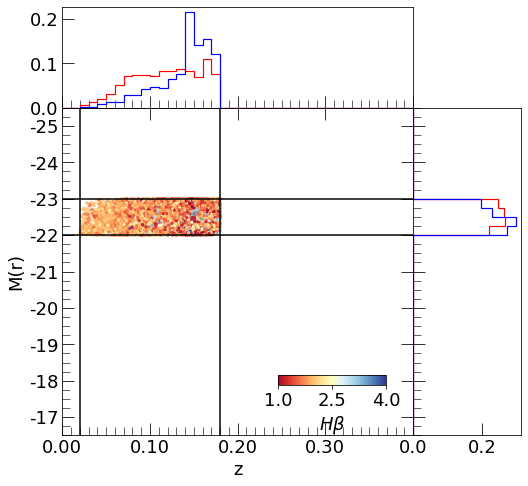

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


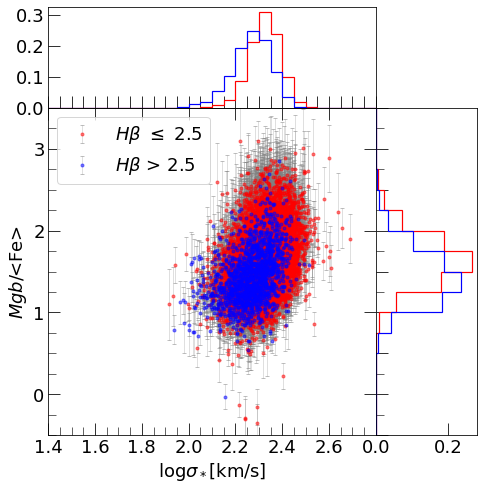

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


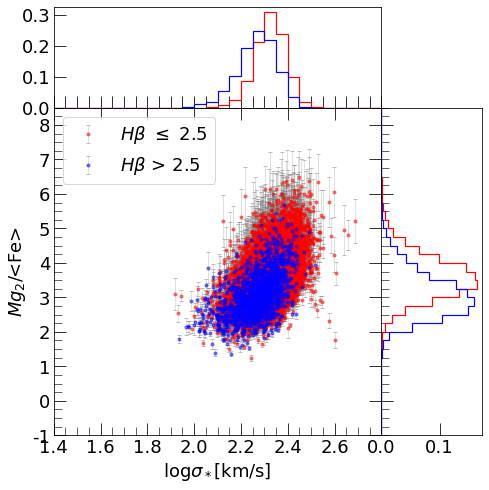

<ipython-input-13-8d127c200c08>:67: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-13-8d127c200c08>:68: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]
<ipython-input-13-8d127c200c08>:76: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-13-8d127c200c08>:77: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


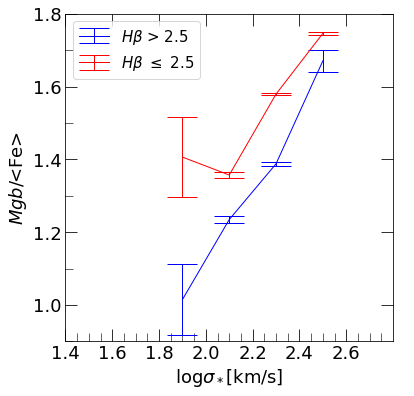

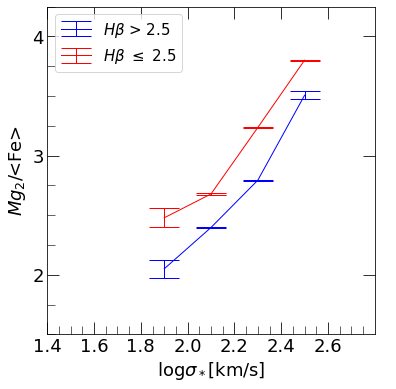

At {-22 < z <= -21}: The # of sample is 7003
The # of color red:  6475
The # of color blue:  528


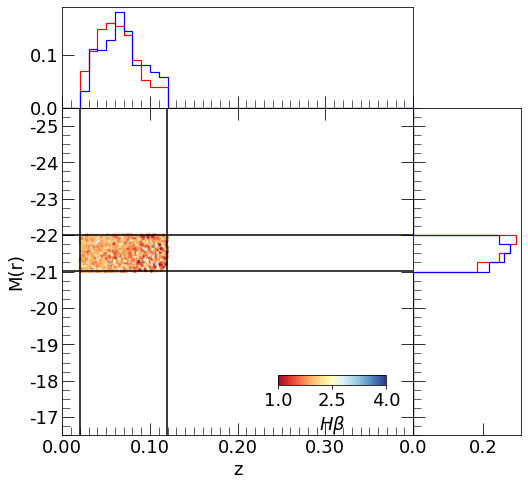

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


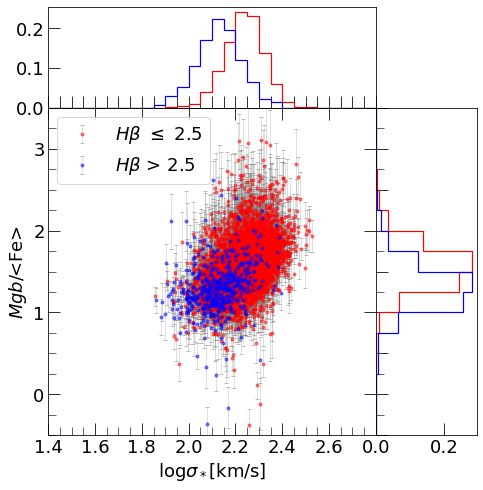

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


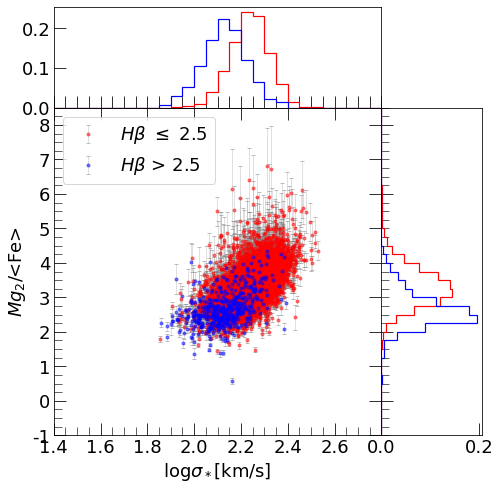

<ipython-input-13-8d127c200c08>:67: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-13-8d127c200c08>:68: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]
<ipython-input-13-8d127c200c08>:76: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-13-8d127c200c08>:77: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


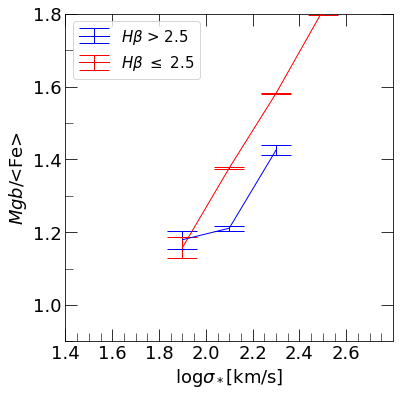

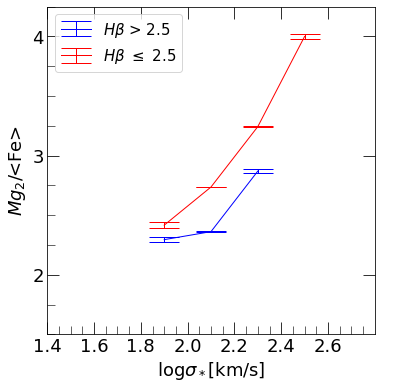

At {-21 < z <= -20}: The # of sample is 2996
The # of color red:  2629
The # of color blue:  367


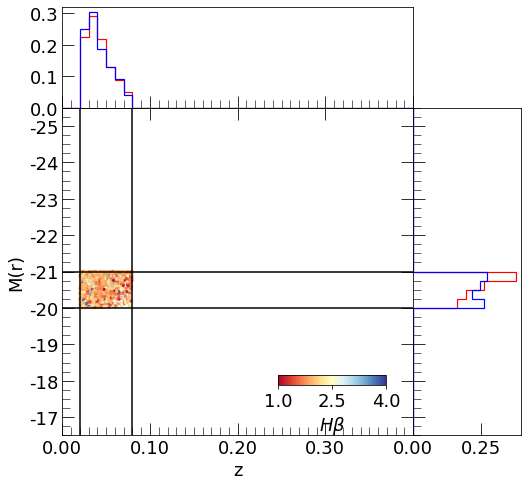

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]


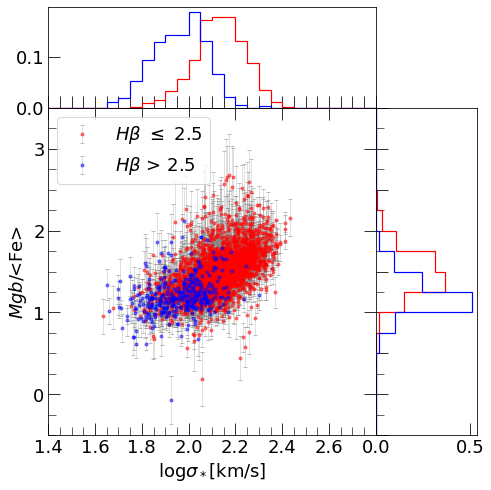

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]


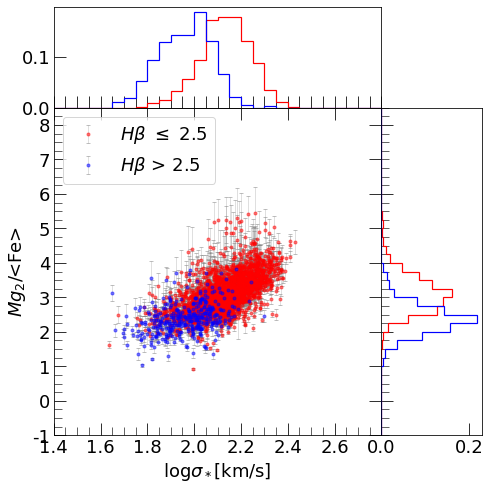

<ipython-input-13-8d127c200c08>:67: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-13-8d127c200c08>:68: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]


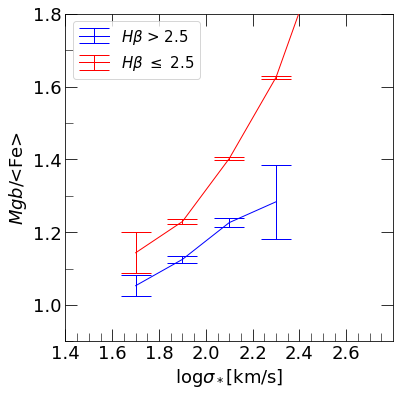

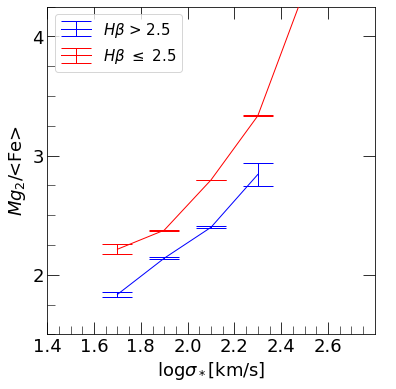

At {-20 < z <= -19}: The # of sample is 751
The # of color red:  561
The # of color blue:  190


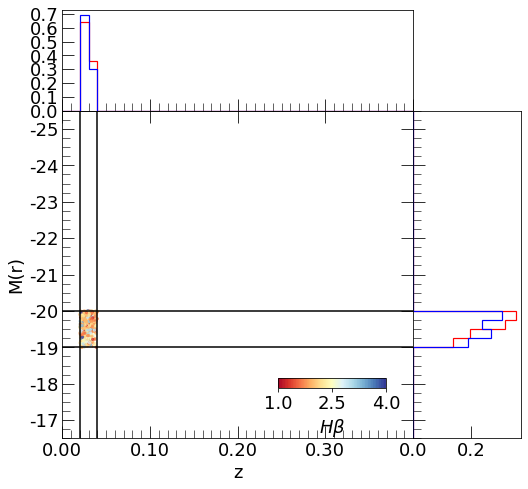

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


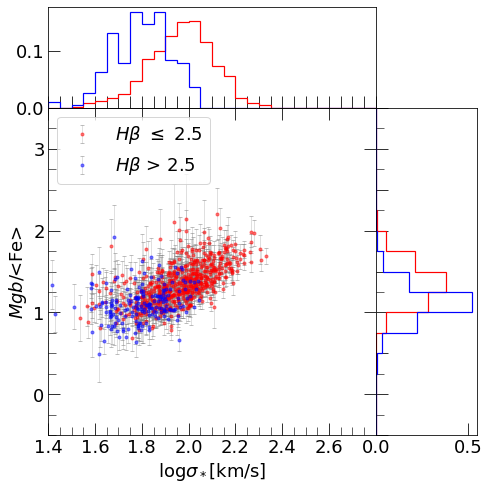

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


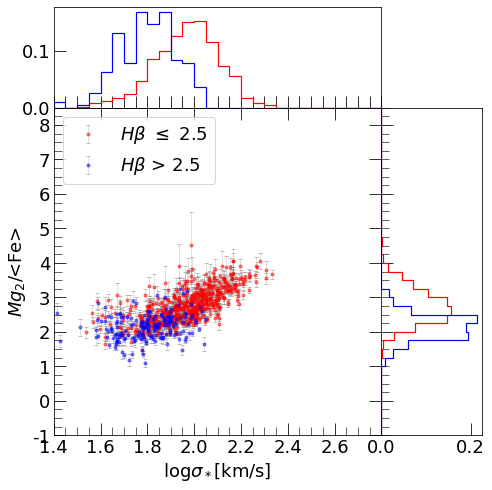

<ipython-input-13-8d127c200c08>:67: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-13-8d127c200c08>:68: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]
<ipython-input-13-8d127c200c08>:76: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-13-8d127c200c08>:77: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


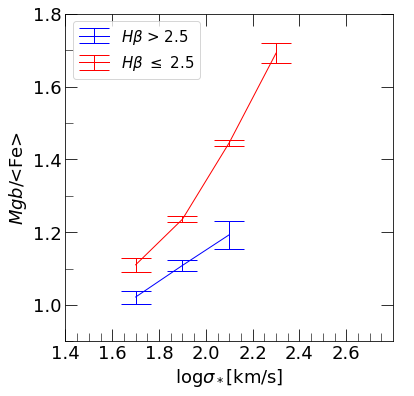

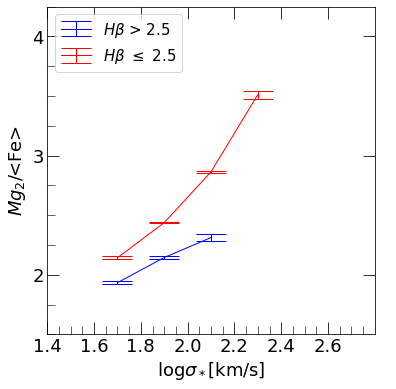

In [56]:
ycrits = np.arange(-19, -24, -1)
xcrits = [0.18, 0.12, 0.08, 0.04]

for ycrit in range(len(ycrits)-1):
    upper = ycrits[::-1][ycrit+1]
    lower = ycrits[::-1][ycrit]
    w = np.where((Mr_ori > lower) &(Mr_ori <= upper) &(redshit_phot_ori>=0.02) &(redshit_phot_ori<xcrits[ycrit]))
    data, galex, morp, mpa_emi, mpa_emi_ew, Mr = data_ori[w], galex_ori[w], morp_ori[w], mpa_emi_ori[w], mpa_emi_ew_ori[w], Mr_ori[w]
    print('='*100)
    print('At {{{} < z <= {}}}: The # of sample is {}'.format(lower, upper,len(data)))

    plot_z_vs_Mr(data['z'], Mr, color=mpa_emi['LICK_HB'], colorname=r'$H\beta$')
#     plot_mass_index(indices=mpa_emi,stellarmass=mpa_emi['V_DISPEFF'],color=mpa_emi['LICK_HB'],colorname=r'$H\beta$')
#     plot_mass_vs_meanFe(indices=mpa_emi,stellarmass=mpa_emi['V_DISPEFF'],color=mpa_emi['LICK_HB'],colorname=r'$H\beta$')
#     plot_mass_vs_MgFe(indices=mpa_emi,stellarmass=mpa_emi['V_DISPEFF'],color=mpa_emi['LICK_HB'],colorname=r'$H\beta$')
    plot_mass_vs_X_over_meanFe(indices=mpa_emi,color=mpa_emi['LICK_HB'],colorname=r'$H\beta$')
    plot_mass_vs_X_over_meanFe_slope(indices=mpa_emi,color=mpa_emi['LICK_HB'],colorname=r'$H\beta$')

## 마그네슘 함량 외 다른 원소의 함량 지표의 분포 확인

At {-23 < z <= -22}: The # of sample is 17601
The # of color red:  15832
The # of color blue:  1769


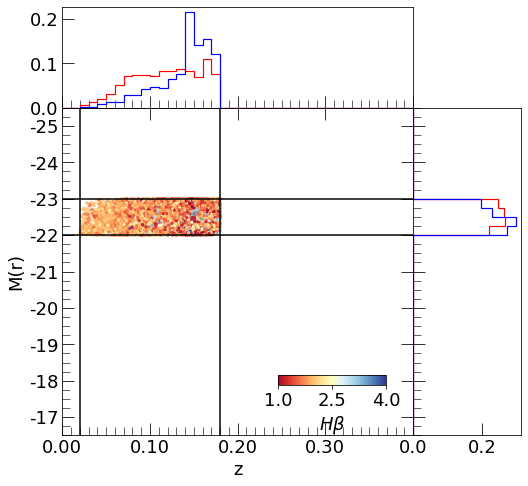

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


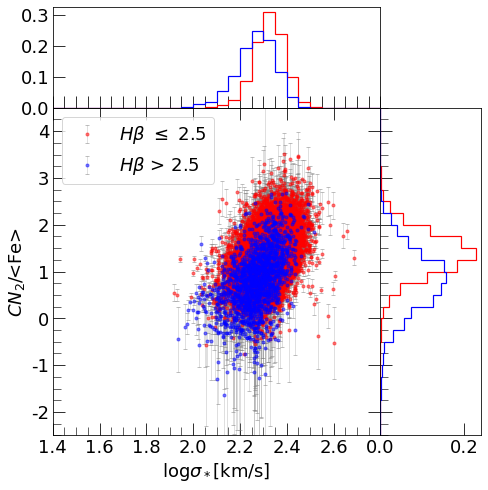

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


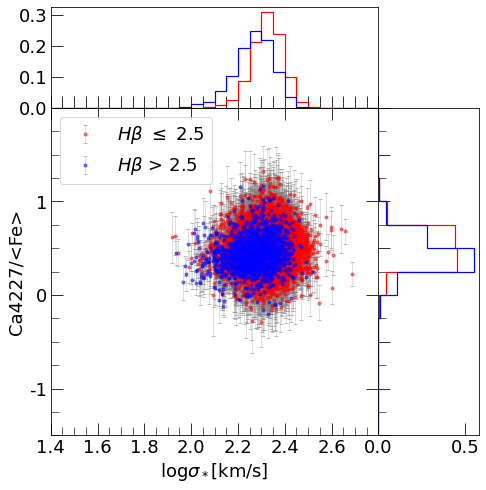

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


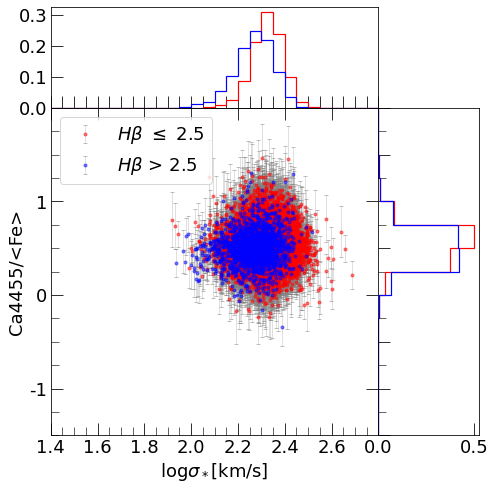

<ipython-input-13-8d127c200c08>:67: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-13-8d127c200c08>:68: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]
<ipython-input-13-8d127c200c08>:76: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-13-8d127c200c08>:77: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


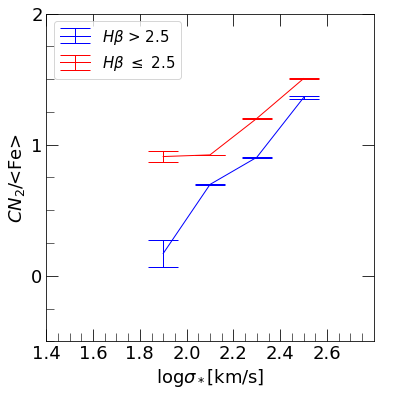

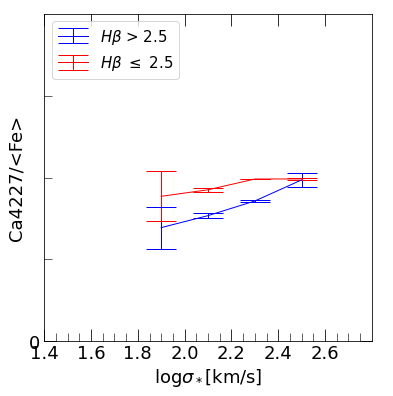

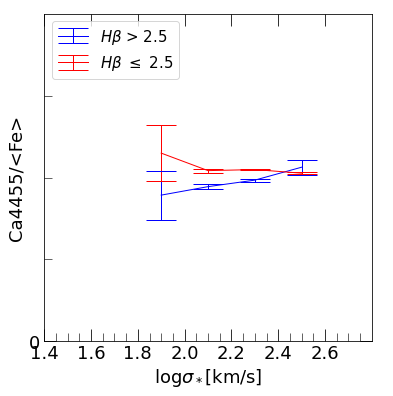

At {-22 < z <= -21}: The # of sample is 7003
The # of color red:  6475
The # of color blue:  528


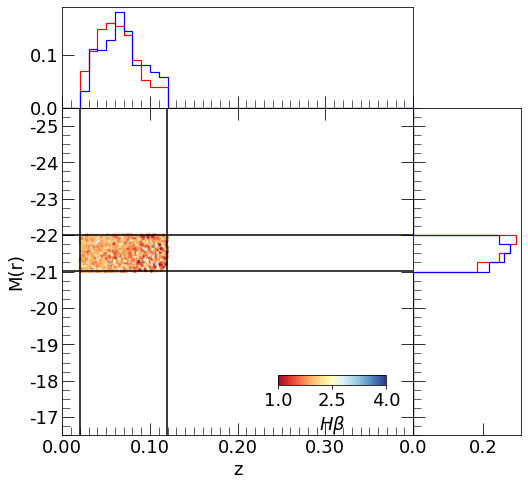

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


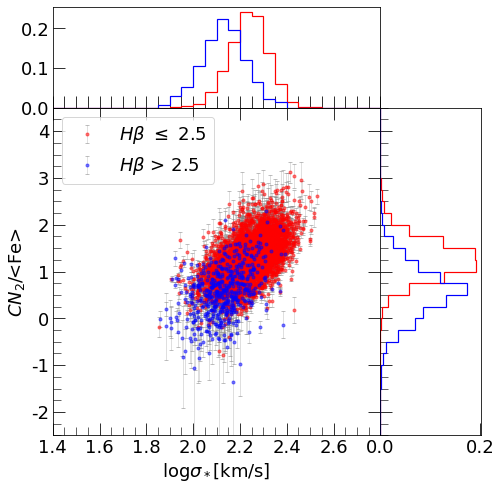

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


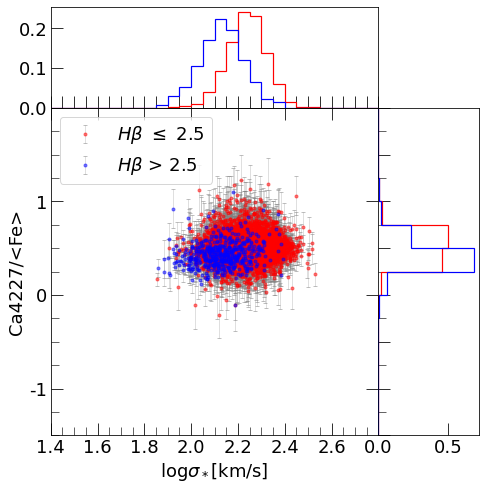

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


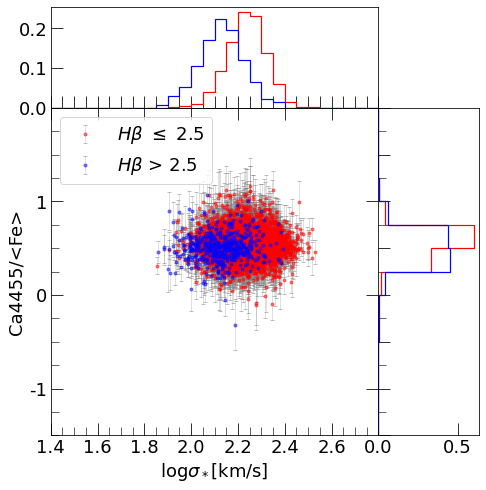

<ipython-input-13-8d127c200c08>:67: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-13-8d127c200c08>:68: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]
<ipython-input-13-8d127c200c08>:76: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-13-8d127c200c08>:77: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


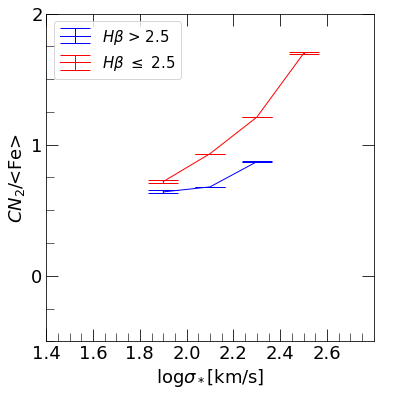

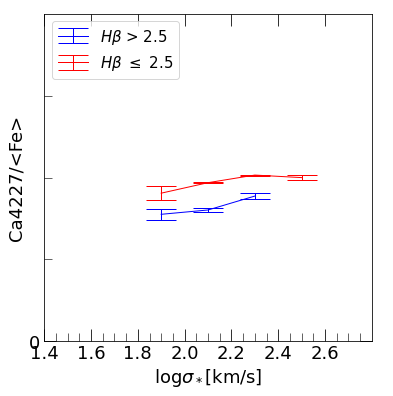

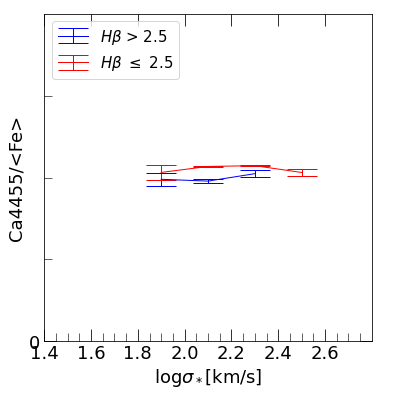

At {-21 < z <= -20}: The # of sample is 2996
The # of color red:  2629
The # of color blue:  367


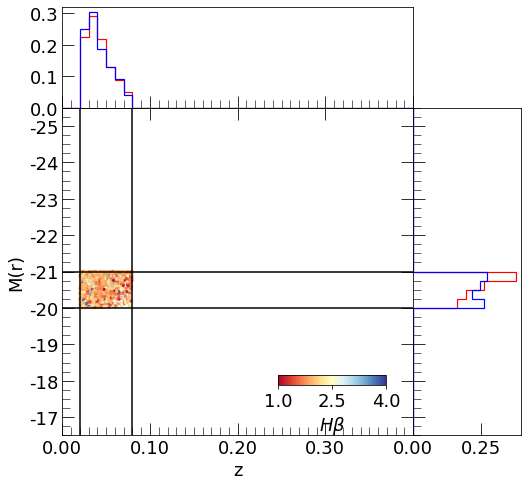

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]


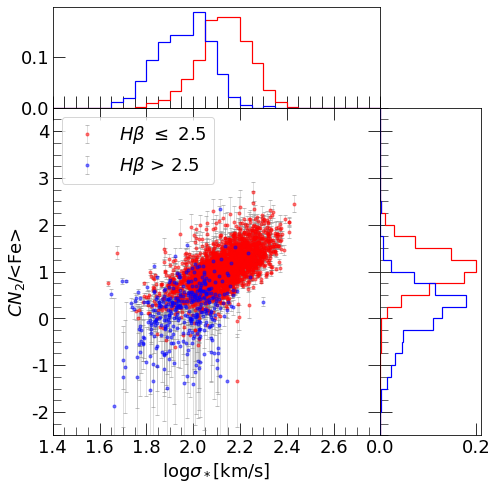

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]


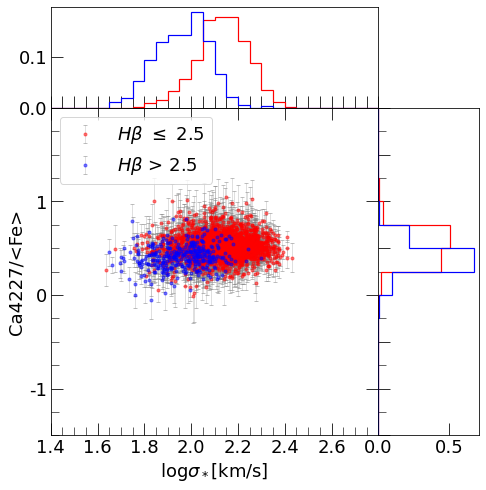

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]


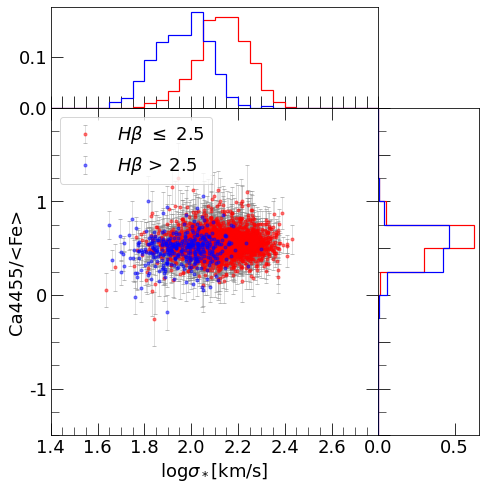

<ipython-input-13-8d127c200c08>:67: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-13-8d127c200c08>:68: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]


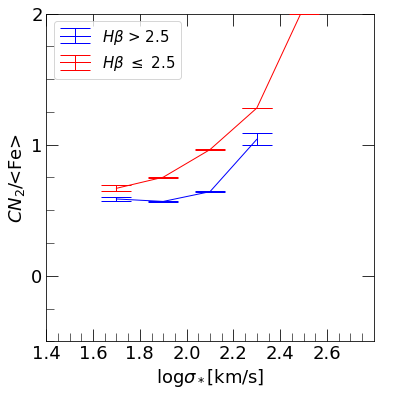

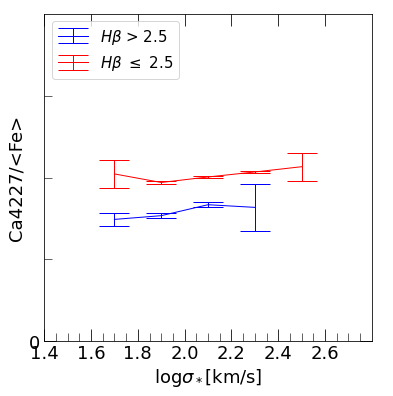

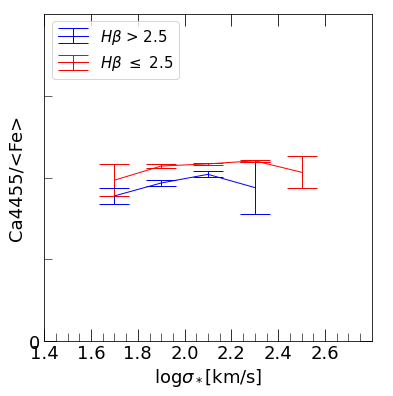

At {-20 < z <= -19}: The # of sample is 751
The # of color red:  561
The # of color blue:  190


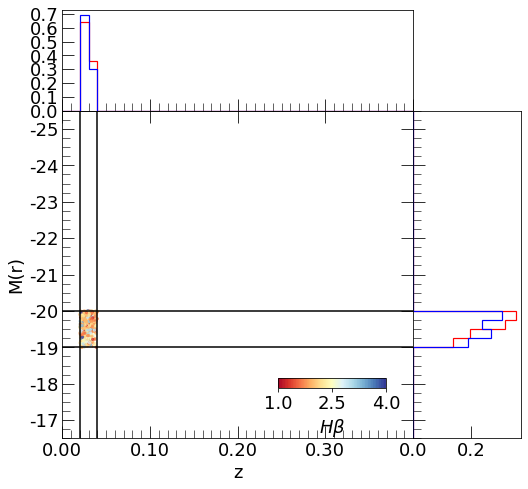

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


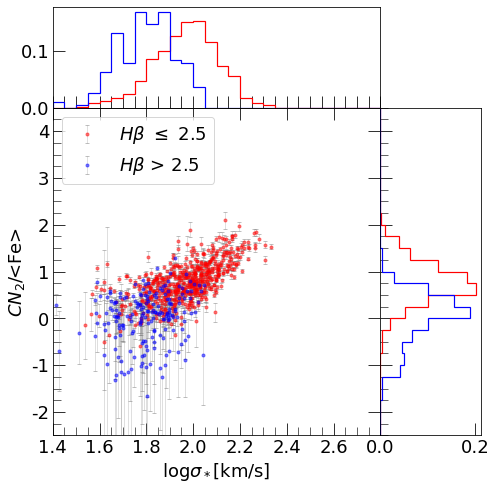

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


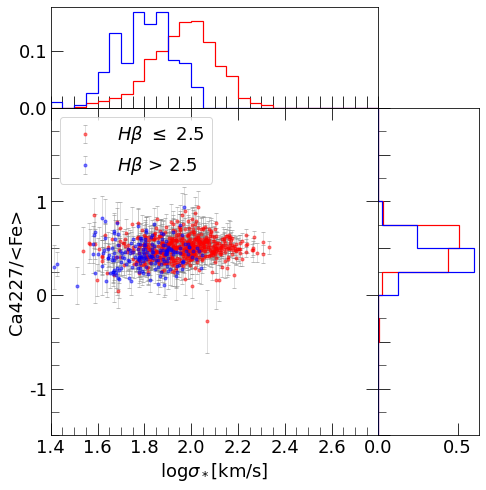

<ipython-input-12-27ae6ce09078>:66: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-12-27ae6ce09078>:67: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b = [np.sqrt(1/i)[0] for i in bottom_b.statistic]
<ipython-input-12-27ae6ce09078>:75: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-12-27ae6ce09078>:76: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


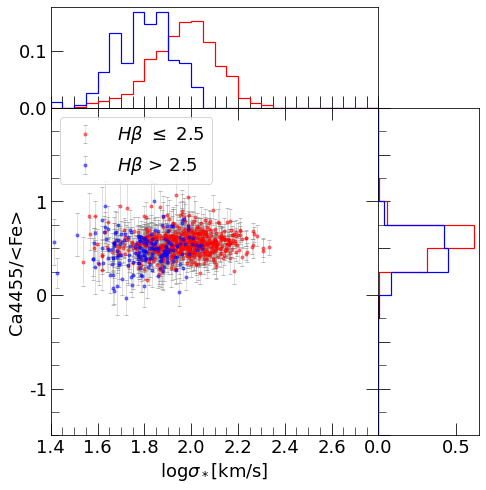

<ipython-input-13-8d127c200c08>:67: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_blue = top_b.statistic/bottom_b.statistic
<ipython-input-13-8d127c200c08>:68: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_b  = [np.sqrt(1/i)[0]for i in bottom_b.statistic]
<ipython-input-13-8d127c200c08>:76: RuntimeWarning: invalid value encountered in true_divide
  Mean_weighted_red = top_r.statistic / bottom_r.statistic
<ipython-input-13-8d127c200c08>:77: RuntimeWarning: divide by zero encountered in true_divide
  error_in_the_weighted_mean_r = [np.sqrt(1/i)[0] for i in bottom_r.statistic]


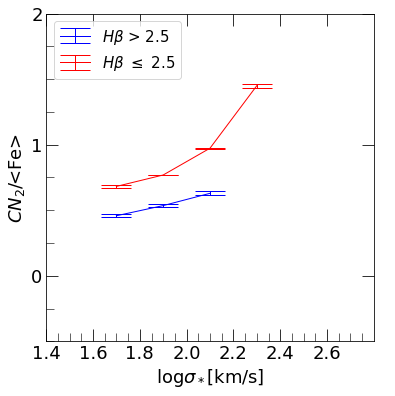

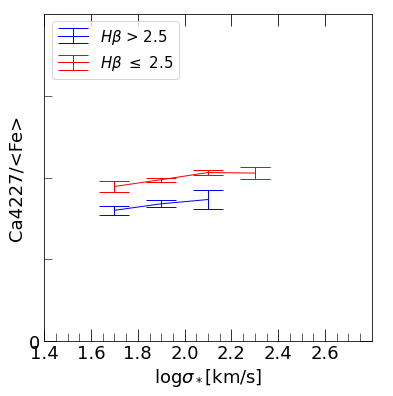

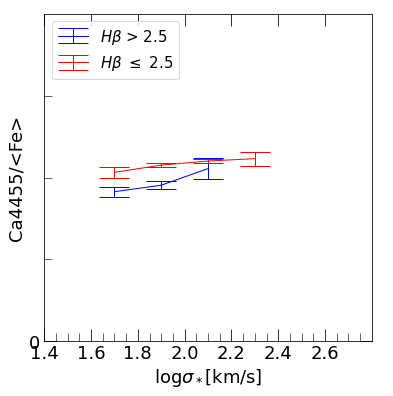

In [57]:
ycrits = np.arange(-19, -24, -1)
xcrits = [0.18, 0.12, 0.08, 0.04]

for ycrit in range(len(ycrits)-1):
    upper = ycrits[::-1][ycrit+1]
    lower = ycrits[::-1][ycrit]
    w = np.where((Mr_ori > lower) &(Mr_ori <= upper) &(redshit_phot_ori>=0.02) &(redshit_phot_ori<xcrits[ycrit]))
    data, galex, morp, mpa_emi, mpa_emi_ew, Mr = data_ori[w], galex_ori[w], morp_ori[w], mpa_emi_ori[w], mpa_emi_ew_ori[w], Mr_ori[w]
    print('='*100)
    print('At {{{} < z <= {}}}: The # of sample is {}'.format(lower, upper,len(data)))

    plot_z_vs_Mr(data['z'], Mr, color=mpa_emi['LICK_HB'], colorname=r'$H\beta$')
#     plot_mass_index(indices=mpa_emi,stellarmass=mpa_emi['V_DISPEFF'],color=mpa_emi['LICK_HB'],colorname=r'$H\beta$')
#     plot_mass_vs_meanFe(indices=mpa_emi,stellarmass=mpa_emi['V_DISPEFF'],color=mpa_emi['LICK_HB'],colorname=r'$H\beta$')
#     plot_mass_vs_MgFe(indices=mpa_emi,stellarmass=mpa_emi['V_DISPEFF'],color=mpa_emi['LICK_HB'],colorname=r'$H\beta$')
#     plot_mass_vs_X_over_meanFe(indices=mpa_emi,stellarmass=mpa_emi['V_DISPEFF'],color=mpa_emi['LICK_HB'],colorname=r'$H\beta$',elements=['CN2', 'CA4227','CA4455'], ylabels=['$CN_2$', 'Ca4227','Ca4455'])
    plot_mass_vs_X_over_meanFe(indices=mpa_emi,color=mpa_emi['LICK_HB'],colorname=r'$H\beta$',elements=['CN2', 'CA4227','CA4455'], ylabels=['$CN_2$', 'Ca4227','Ca4455'])
    plot_mass_vs_X_over_meanFe_slope(indices=mpa_emi,color=mpa_emi['LICK_HB'],colorname=r'$H\beta$',elements=['CN2', 'CA4227','CA4455'], ylabels=['$CN_2$', 'Ca4227','Ca4455'])


# 8. 📌인사이트 도출
## 가설 검정 결과 젊은 별은 은하의 마그네슘 함량 지표를 감소시키는 새로운 원인이다.
## 따라서 은하의 마그네슘 함량 추정의 정확도 향상을 위해 젊은 별의 영향을 받은 표본을 제외할 더 좋은 방법이 필요하다.